# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

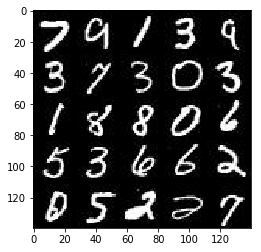

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

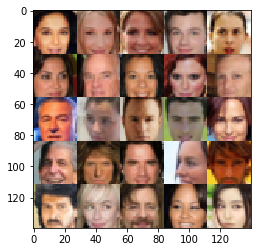

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [99]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels),name='input_real')
    input_z = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learn_rate')
    

    return input_images, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [145]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        #28*28*3
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        relu_h1 = tf.maximum(alpha * h1, h1)
        
        #14*14*64
        h2= tf.layers.conv2d(relu_h1, 128, 5, strides=2, padding="same")
        bn_h2=tf.layers.batch_normalization(h2,training=True)
        relu_h2 = tf.maximum(alpha * bn_h2, bn_h2)
        
        #7*7*128
        h3= tf.layers.conv2d(relu_h2, 256, 5, strides=1, padding="same")
        bn_h3=tf.layers.batch_normalization(h3,training=True)
        relu_h3 = tf.maximum(alpha * bn_h3, bn_h3)
        
        #7*7*256
        flat = tf.reshape(relu_h3,(-1,7*7*512))
        logits=tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [149]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
      
    # TODO: Implement Function
    alpha=0.2
    #ideally we should have a reuse argument as well
    with tf.variable_scope('generator',reuse=not is_train):
        #7*7*512
        h1=tf.layers.dense(z,7*7*512)
        
        h1=tf.reshape(h1,(-1,7,7,512))
        h1=tf.layers.batch_normalization(h1, training=is_train)
        h1=tf.maximum(alpha*h1,h1)
        #7*7*512 now
        
        h2=tf.layers.conv2d_transpose(h1,256,5,strides=1,padding='same')
        h2=tf.layers.batch_normalization(h2, training=is_train)
        h2=tf.maximum(alpha*h2,h2)
        #14*14*256 now
        
        h3=tf.layers.conv2d_transpose(h2,128,5,strides=2,padding='same')
        h3=tf.layers.batch_normalization(h3, training=is_train)
        h3=tf.maximum(alpha*h3,h3)
        #28*28*128
        
        logits=tf.layers.conv2d_transpose(h3,out_channel_dim,5,strides=2,padding='same')
        #28*28*out_channel_dim
        
        out=tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [150]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model=generator(input_z,out_channel_dim)
    d_model_real,d_logits_real=discriminator(input_real)
    d_model_fake,d_logits_fake=discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [151]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [152]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [153]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real,input_z,learn_rate=model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss,g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    show_every=100
    print_every=20
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    samples, losses = [], []
    steps = 0
    starter_learning_rate=learning_rate
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
                    
    return losses    

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.4386... Generator Loss: 0.0175
Epoch 1/2... Discriminator Loss: 1.3031... Generator Loss: 1.5252
Epoch 1/2... Discriminator Loss: 3.1429... Generator Loss: 0.6588
Epoch 1/2... Discriminator Loss: 4.3729... Generator Loss: 0.0778
Epoch 1/2... Discriminator Loss: 4.8282... Generator Loss: 0.0115


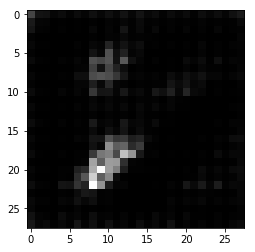

Epoch 1/2... Discriminator Loss: 4.2887... Generator Loss: 0.0222
Epoch 1/2... Discriminator Loss: 3.2846... Generator Loss: 0.3015
Epoch 1/2... Discriminator Loss: 1.2918... Generator Loss: 0.7867
Epoch 1/2... Discriminator Loss: 0.6456... Generator Loss: 2.0553
Epoch 1/2... Discriminator Loss: 1.5564... Generator Loss: 1.0763


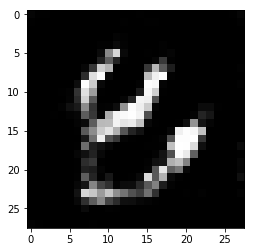

Epoch 1/2... Discriminator Loss: 1.3806... Generator Loss: 3.4085
Epoch 1/2... Discriminator Loss: 2.2093... Generator Loss: 2.5167
Epoch 1/2... Discriminator Loss: 3.2605... Generator Loss: 3.2040
Epoch 1/2... Discriminator Loss: 3.0728... Generator Loss: 0.1305
Epoch 1/2... Discriminator Loss: 2.6527... Generator Loss: 0.0956


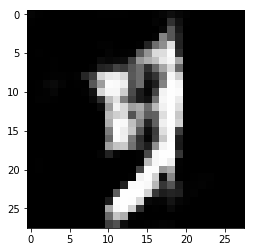

Epoch 1/2... Discriminator Loss: 2.0445... Generator Loss: 0.8686
Epoch 1/2... Discriminator Loss: 1.0412... Generator Loss: 1.7847
Epoch 1/2... Discriminator Loss: 2.3601... Generator Loss: 2.6811
Epoch 1/2... Discriminator Loss: 1.2673... Generator Loss: 0.7492
Epoch 1/2... Discriminator Loss: 0.9629... Generator Loss: 1.4717


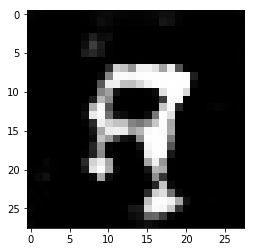

Epoch 1/2... Discriminator Loss: 2.4700... Generator Loss: 0.3203
Epoch 1/2... Discriminator Loss: 1.2126... Generator Loss: 1.4257
Epoch 1/2... Discriminator Loss: 2.5251... Generator Loss: 0.1120
Epoch 1/2... Discriminator Loss: 1.3296... Generator Loss: 0.5803
Epoch 1/2... Discriminator Loss: 2.5758... Generator Loss: 0.1356


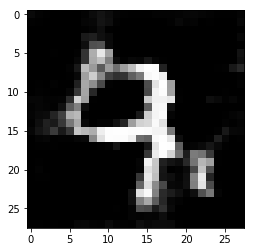

Epoch 1/2... Discriminator Loss: 1.4206... Generator Loss: 1.2832
Epoch 1/2... Discriminator Loss: 1.4126... Generator Loss: 1.3767
Epoch 1/2... Discriminator Loss: 2.3314... Generator Loss: 2.8272
Epoch 1/2... Discriminator Loss: 1.7817... Generator Loss: 0.3730
Epoch 1/2... Discriminator Loss: 1.6850... Generator Loss: 0.3117


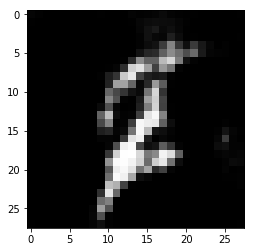

Epoch 1/2... Discriminator Loss: 1.1882... Generator Loss: 0.7211
Epoch 1/2... Discriminator Loss: 1.7653... Generator Loss: 0.4567
Epoch 1/2... Discriminator Loss: 1.6627... Generator Loss: 0.5468
Epoch 1/2... Discriminator Loss: 1.1015... Generator Loss: 2.1345
Epoch 1/2... Discriminator Loss: 1.2926... Generator Loss: 0.8027


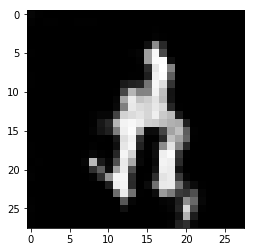

Epoch 1/2... Discriminator Loss: 1.2016... Generator Loss: 0.6923
Epoch 1/2... Discriminator Loss: 1.4319... Generator Loss: 0.7734
Epoch 1/2... Discriminator Loss: 2.0094... Generator Loss: 0.2579
Epoch 1/2... Discriminator Loss: 2.9460... Generator Loss: 0.0784
Epoch 1/2... Discriminator Loss: 1.5555... Generator Loss: 1.3405


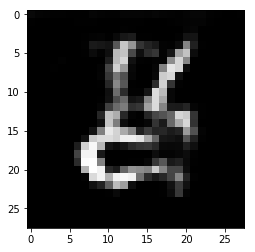

Epoch 1/2... Discriminator Loss: 1.2098... Generator Loss: 1.0510
Epoch 1/2... Discriminator Loss: 0.7649... Generator Loss: 1.7328
Epoch 1/2... Discriminator Loss: 1.3986... Generator Loss: 0.9049
Epoch 1/2... Discriminator Loss: 1.4867... Generator Loss: 2.0279
Epoch 1/2... Discriminator Loss: 1.5986... Generator Loss: 0.3892


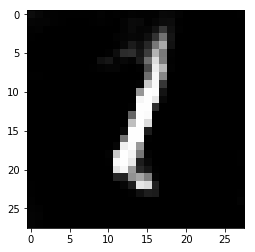

Epoch 1/2... Discriminator Loss: 2.1121... Generator Loss: 0.1945
Epoch 1/2... Discriminator Loss: 0.7899... Generator Loss: 1.8322
Epoch 1/2... Discriminator Loss: 1.2108... Generator Loss: 0.8996
Epoch 1/2... Discriminator Loss: 1.5902... Generator Loss: 0.7637
Epoch 1/2... Discriminator Loss: 2.1837... Generator Loss: 0.1640


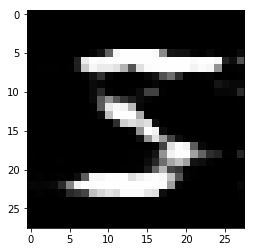

Epoch 1/2... Discriminator Loss: 1.7393... Generator Loss: 3.5378
Epoch 1/2... Discriminator Loss: 1.7247... Generator Loss: 0.2740
Epoch 1/2... Discriminator Loss: 1.2611... Generator Loss: 1.4478
Epoch 1/2... Discriminator Loss: 1.2170... Generator Loss: 0.5626
Epoch 1/2... Discriminator Loss: 1.3437... Generator Loss: 2.1024


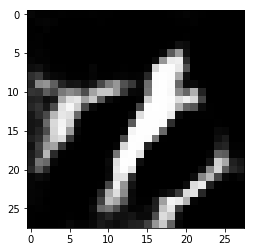

Epoch 1/2... Discriminator Loss: 0.9787... Generator Loss: 0.8431
Epoch 1/2... Discriminator Loss: 1.0695... Generator Loss: 0.9776
Epoch 1/2... Discriminator Loss: 1.9188... Generator Loss: 0.4132
Epoch 1/2... Discriminator Loss: 1.5880... Generator Loss: 3.8939
Epoch 1/2... Discriminator Loss: 1.1160... Generator Loss: 1.1492


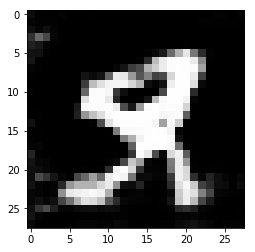

Epoch 1/2... Discriminator Loss: 1.6207... Generator Loss: 0.2927
Epoch 1/2... Discriminator Loss: 0.9885... Generator Loss: 1.0980
Epoch 1/2... Discriminator Loss: 0.9182... Generator Loss: 1.1329
Epoch 1/2... Discriminator Loss: 0.8358... Generator Loss: 1.1914
Epoch 1/2... Discriminator Loss: 2.6047... Generator Loss: 0.3071


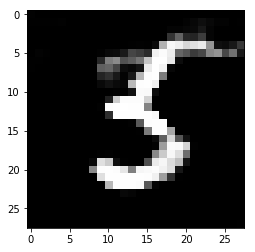

Epoch 1/2... Discriminator Loss: 1.7911... Generator Loss: 0.2876
Epoch 1/2... Discriminator Loss: 1.6209... Generator Loss: 0.3897
Epoch 1/2... Discriminator Loss: 1.7779... Generator Loss: 0.2711
Epoch 1/2... Discriminator Loss: 1.2339... Generator Loss: 0.6385
Epoch 1/2... Discriminator Loss: 1.2466... Generator Loss: 2.2027


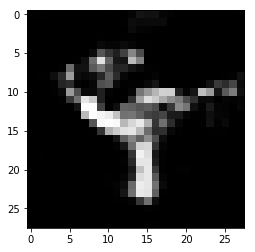

Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.3966
Epoch 1/2... Discriminator Loss: 2.1511... Generator Loss: 0.2541
Epoch 1/2... Discriminator Loss: 0.8556... Generator Loss: 3.3437
Epoch 1/2... Discriminator Loss: 1.1658... Generator Loss: 0.6567
Epoch 1/2... Discriminator Loss: 1.4493... Generator Loss: 0.6231


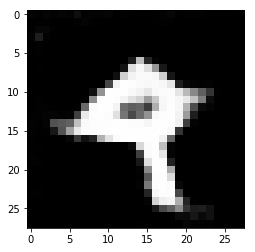

Epoch 1/2... Discriminator Loss: 1.0355... Generator Loss: 0.6652
Epoch 1/2... Discriminator Loss: 0.8598... Generator Loss: 1.1273
Epoch 1/2... Discriminator Loss: 0.8907... Generator Loss: 0.9866
Epoch 1/2... Discriminator Loss: 0.8277... Generator Loss: 0.9969
Epoch 1/2... Discriminator Loss: 1.0964... Generator Loss: 0.7077


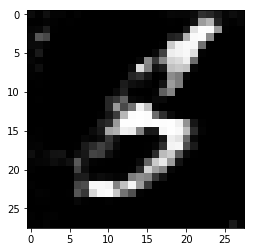

Epoch 1/2... Discriminator Loss: 1.4151... Generator Loss: 3.8003
Epoch 1/2... Discriminator Loss: 1.6911... Generator Loss: 0.3525
Epoch 1/2... Discriminator Loss: 1.8760... Generator Loss: 0.2381
Epoch 1/2... Discriminator Loss: 1.8340... Generator Loss: 0.3459
Epoch 1/2... Discriminator Loss: 1.5328... Generator Loss: 0.4385


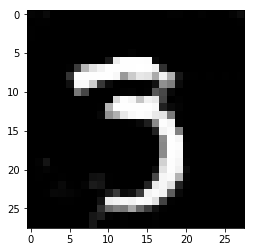

Epoch 1/2... Discriminator Loss: 2.5116... Generator Loss: 0.1973
Epoch 1/2... Discriminator Loss: 1.4396... Generator Loss: 0.6342
Epoch 1/2... Discriminator Loss: 0.8478... Generator Loss: 0.9120
Epoch 1/2... Discriminator Loss: 0.7676... Generator Loss: 0.8268
Epoch 1/2... Discriminator Loss: 0.8578... Generator Loss: 1.8000


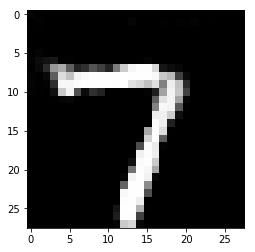

Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.6100
Epoch 1/2... Discriminator Loss: 1.6175... Generator Loss: 0.5808
Epoch 1/2... Discriminator Loss: 3.1857... Generator Loss: 0.2368
Epoch 2/2... Discriminator Loss: 0.9331... Generator Loss: 1.1887
Epoch 2/2... Discriminator Loss: 1.1574... Generator Loss: 0.5625


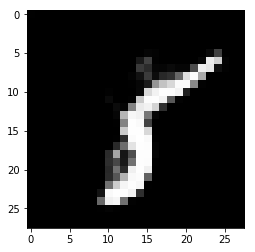

Epoch 2/2... Discriminator Loss: 0.8391... Generator Loss: 1.0210
Epoch 2/2... Discriminator Loss: 1.0094... Generator Loss: 0.7736
Epoch 2/2... Discriminator Loss: 1.3471... Generator Loss: 0.8427
Epoch 2/2... Discriminator Loss: 1.0085... Generator Loss: 1.1655
Epoch 2/2... Discriminator Loss: 0.4779... Generator Loss: 1.6500


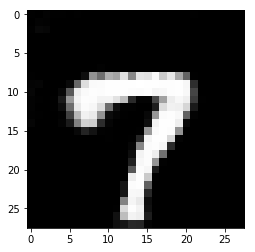

Epoch 2/2... Discriminator Loss: 0.9117... Generator Loss: 1.5543
Epoch 2/2... Discriminator Loss: 0.9664... Generator Loss: 0.8096
Epoch 2/2... Discriminator Loss: 1.4174... Generator Loss: 0.4558
Epoch 2/2... Discriminator Loss: 2.6448... Generator Loss: 0.2752
Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 1.0619


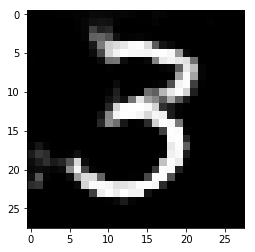

Epoch 2/2... Discriminator Loss: 3.5342... Generator Loss: 4.5278
Epoch 2/2... Discriminator Loss: 1.6494... Generator Loss: 0.4062
Epoch 2/2... Discriminator Loss: 1.4258... Generator Loss: 0.5309
Epoch 2/2... Discriminator Loss: 1.4556... Generator Loss: 0.6770
Epoch 2/2... Discriminator Loss: 0.4584... Generator Loss: 2.7578


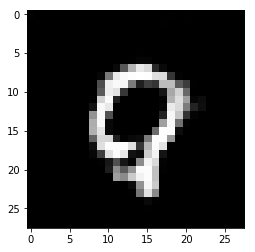

Epoch 2/2... Discriminator Loss: 0.9314... Generator Loss: 0.9646
Epoch 2/2... Discriminator Loss: 0.6765... Generator Loss: 1.8237
Epoch 2/2... Discriminator Loss: 1.5103... Generator Loss: 4.3565
Epoch 2/2... Discriminator Loss: 1.3830... Generator Loss: 3.4581
Epoch 2/2... Discriminator Loss: 3.4334... Generator Loss: 0.0869


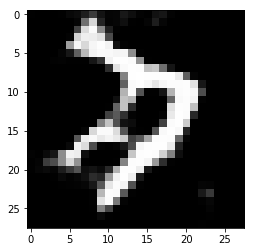

Epoch 2/2... Discriminator Loss: 0.4953... Generator Loss: 1.7411
Epoch 2/2... Discriminator Loss: 0.4330... Generator Loss: 1.5800
Epoch 2/2... Discriminator Loss: 2.5451... Generator Loss: 0.2417
Epoch 2/2... Discriminator Loss: 1.2145... Generator Loss: 0.6427
Epoch 2/2... Discriminator Loss: 3.2024... Generator Loss: 0.1197


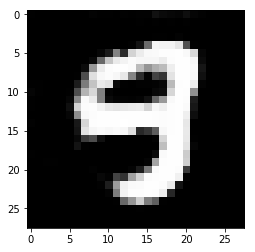

Epoch 2/2... Discriminator Loss: 0.7833... Generator Loss: 0.9996
Epoch 2/2... Discriminator Loss: 0.9808... Generator Loss: 0.8293
Epoch 2/2... Discriminator Loss: 3.4973... Generator Loss: 0.1290
Epoch 2/2... Discriminator Loss: 0.9457... Generator Loss: 0.8708
Epoch 2/2... Discriminator Loss: 0.8695... Generator Loss: 0.9975


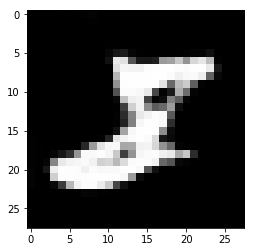

Epoch 2/2... Discriminator Loss: 0.8174... Generator Loss: 1.0890
Epoch 2/2... Discriminator Loss: 1.1191... Generator Loss: 0.7648
Epoch 2/2... Discriminator Loss: 2.4924... Generator Loss: 0.2534
Epoch 2/2... Discriminator Loss: 1.5430... Generator Loss: 0.5141
Epoch 2/2... Discriminator Loss: 1.8541... Generator Loss: 0.3113


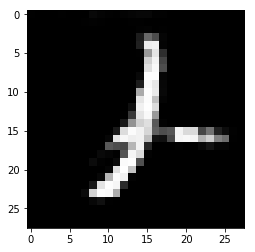

Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 0.9332
Epoch 2/2... Discriminator Loss: 0.5053... Generator Loss: 2.0241
Epoch 2/2... Discriminator Loss: 1.7631... Generator Loss: 0.3194
Epoch 2/2... Discriminator Loss: 0.7567... Generator Loss: 1.1349
Epoch 2/2... Discriminator Loss: 1.7261... Generator Loss: 0.5558


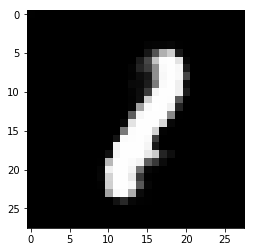

Epoch 2/2... Discriminator Loss: 0.6294... Generator Loss: 2.5235
Epoch 2/2... Discriminator Loss: 0.8420... Generator Loss: 1.0698
Epoch 2/2... Discriminator Loss: 1.0062... Generator Loss: 3.6782
Epoch 2/2... Discriminator Loss: 1.2835... Generator Loss: 0.6230
Epoch 2/2... Discriminator Loss: 1.0910... Generator Loss: 1.4272


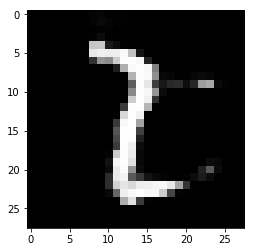

Epoch 2/2... Discriminator Loss: 0.3125... Generator Loss: 1.6549
Epoch 2/2... Discriminator Loss: 1.5042... Generator Loss: 0.3968
Epoch 2/2... Discriminator Loss: 0.7839... Generator Loss: 1.7491
Epoch 2/2... Discriminator Loss: 2.2990... Generator Loss: 0.2726
Epoch 2/2... Discriminator Loss: 0.9420... Generator Loss: 1.2703


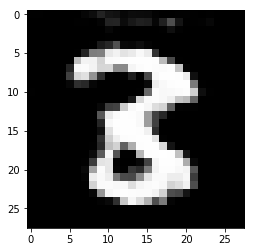

Epoch 2/2... Discriminator Loss: 0.4290... Generator Loss: 1.8777
Epoch 2/2... Discriminator Loss: 0.6951... Generator Loss: 1.0313
Epoch 2/2... Discriminator Loss: 3.1233... Generator Loss: 0.0902
Epoch 2/2... Discriminator Loss: 0.8035... Generator Loss: 1.3618
Epoch 2/2... Discriminator Loss: 2.8896... Generator Loss: 0.1570


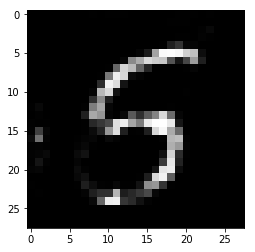

Epoch 2/2... Discriminator Loss: 1.5905... Generator Loss: 0.5737
Epoch 2/2... Discriminator Loss: 1.8164... Generator Loss: 0.4337
Epoch 2/2... Discriminator Loss: 0.4784... Generator Loss: 1.3555
Epoch 2/2... Discriminator Loss: 1.2636... Generator Loss: 0.5928
Epoch 2/2... Discriminator Loss: 0.5959... Generator Loss: 1.2458


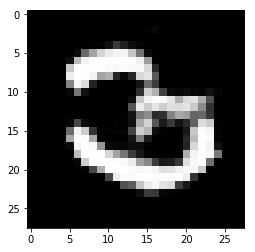

Epoch 2/2... Discriminator Loss: 3.8505... Generator Loss: 0.0618
Epoch 2/2... Discriminator Loss: 0.4942... Generator Loss: 2.7700
Epoch 2/2... Discriminator Loss: 1.2729... Generator Loss: 0.6936
Epoch 2/2... Discriminator Loss: 0.3637... Generator Loss: 2.0952
Epoch 2/2... Discriminator Loss: 0.7980... Generator Loss: 1.3956


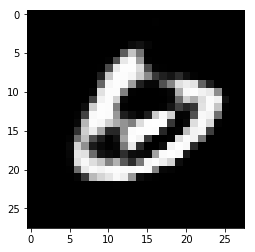

Epoch 2/2... Discriminator Loss: 0.7622... Generator Loss: 1.1151
Epoch 2/2... Discriminator Loss: 0.9578... Generator Loss: 0.8428
Epoch 2/2... Discriminator Loss: 0.9207... Generator Loss: 0.8317
Epoch 2/2... Discriminator Loss: 0.8267... Generator Loss: 0.8040
Epoch 2/2... Discriminator Loss: 4.0233... Generator Loss: 0.0928


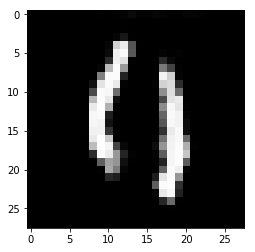

Epoch 2/2... Discriminator Loss: 0.6815... Generator Loss: 1.2475
Epoch 2/2... Discriminator Loss: 0.4828... Generator Loss: 1.8441
Epoch 2/2... Discriminator Loss: 0.7087... Generator Loss: 1.2586
Epoch 2/2... Discriminator Loss: 2.5785... Generator Loss: 0.1407
Epoch 2/2... Discriminator Loss: 1.0252... Generator Loss: 0.9880


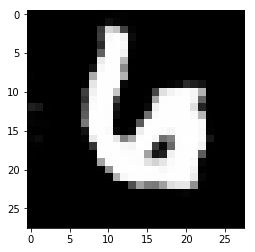

Epoch 2/2... Discriminator Loss: 0.7402... Generator Loss: 1.6273
Epoch 2/2... Discriminator Loss: 0.6260... Generator Loss: 1.5567
Epoch 2/2... Discriminator Loss: 0.4423... Generator Loss: 2.1349
Epoch 2/2... Discriminator Loss: 3.4027... Generator Loss: 0.1040
Epoch 2/2... Discriminator Loss: 0.8375... Generator Loss: 0.9922


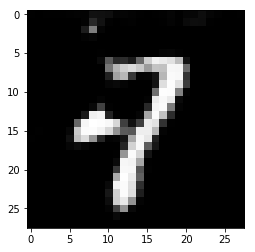

Epoch 2/2... Discriminator Loss: 1.3702... Generator Loss: 0.9891
Epoch 2/2... Discriminator Loss: 0.4525... Generator Loss: 1.8865
Epoch 2/2... Discriminator Loss: 0.2856... Generator Loss: 3.5350
Epoch 2/2... Discriminator Loss: 0.8012... Generator Loss: 2.9707
Epoch 2/2... Discriminator Loss: 2.2139... Generator Loss: 0.2921


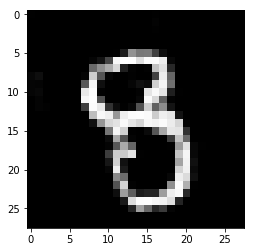

Epoch 2/2... Discriminator Loss: 1.3154... Generator Loss: 0.6730
Epoch 2/2... Discriminator Loss: 1.9203... Generator Loss: 0.3477
Epoch 2/2... Discriminator Loss: 1.1103... Generator Loss: 0.6793
Epoch 2/2... Discriminator Loss: 1.1559... Generator Loss: 0.8775
Epoch 2/2... Discriminator Loss: 0.8911... Generator Loss: 1.4708


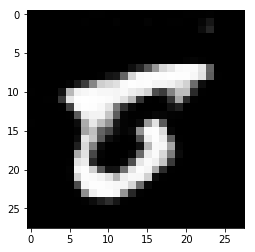

Epoch 2/2... Discriminator Loss: 2.0655... Generator Loss: 0.4549
Epoch 2/2... Discriminator Loss: 2.0935... Generator Loss: 0.3258


In [159]:
#Final Result MNIST Dataset

#alpha = 0.2
batch_size = 32
z_dim = 128
learning_rate = 0.00125
beta1 = 0.5
losses = []


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses=train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

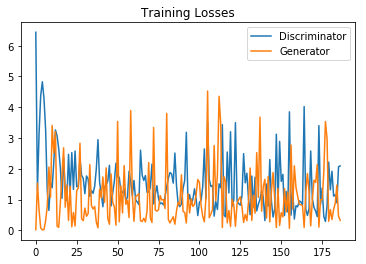

In [160]:
#Final Result MNIST loss graphs
fig, ax = pyplot.subplots()
losses = np.array(losses)
pyplot.plot(losses.T[0], label='Discriminator')
pyplot.plot(losses.T[1], label='Generator')
pyplot.title("Training Losses")
pyplot.legend()

Epoch 1/2... Discriminator Loss: 3.1415... Generator Loss: 7.9101
Epoch 1/2... Discriminator Loss: 4.8033... Generator Loss: 8.1789
Epoch 1/2... Discriminator Loss: 7.8446... Generator Loss: 13.2188
Epoch 1/2... Discriminator Loss: 3.5226... Generator Loss: 0.1689
Epoch 1/2... Discriminator Loss: 2.5699... Generator Loss: 3.1925


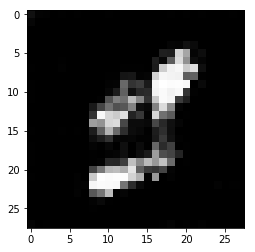

Epoch 1/2... Discriminator Loss: 3.3258... Generator Loss: 0.3387
Epoch 1/2... Discriminator Loss: 4.9105... Generator Loss: 0.0290
Epoch 1/2... Discriminator Loss: 1.2505... Generator Loss: 3.9521
Epoch 1/2... Discriminator Loss: 1.0729... Generator Loss: 3.6428
Epoch 1/2... Discriminator Loss: 3.1849... Generator Loss: 0.1065


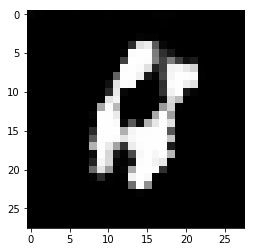

Epoch 1/2... Discriminator Loss: 2.0518... Generator Loss: 3.5148
Epoch 1/2... Discriminator Loss: 2.5627... Generator Loss: 0.1758
Epoch 1/2... Discriminator Loss: 3.7115... Generator Loss: 3.9381
Epoch 1/2... Discriminator Loss: 1.1986... Generator Loss: 1.6986
Epoch 1/2... Discriminator Loss: 2.4661... Generator Loss: 0.2757


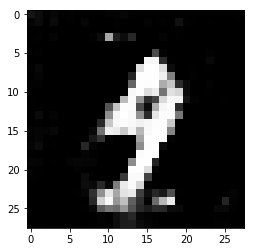

Epoch 1/2... Discriminator Loss: 1.4940... Generator Loss: 0.7229
Epoch 1/2... Discriminator Loss: 3.2625... Generator Loss: 0.0965
Epoch 1/2... Discriminator Loss: 2.9765... Generator Loss: 2.5412
Epoch 1/2... Discriminator Loss: 2.6001... Generator Loss: 0.1545
Epoch 1/2... Discriminator Loss: 1.5234... Generator Loss: 0.8040


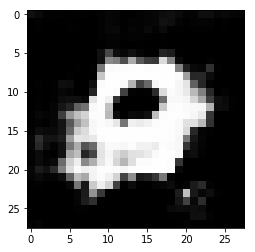

Epoch 1/2... Discriminator Loss: 2.0203... Generator Loss: 0.2421
Epoch 1/2... Discriminator Loss: 1.7445... Generator Loss: 0.3825
Epoch 1/2... Discriminator Loss: 1.3069... Generator Loss: 0.7244
Epoch 1/2... Discriminator Loss: 1.0632... Generator Loss: 1.3131
Epoch 1/2... Discriminator Loss: 1.9323... Generator Loss: 0.2966


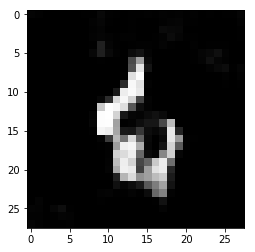

Epoch 1/2... Discriminator Loss: 0.9069... Generator Loss: 0.9135
Epoch 1/2... Discriminator Loss: 1.7536... Generator Loss: 0.3732
Epoch 1/2... Discriminator Loss: 1.4747... Generator Loss: 0.4670
Epoch 1/2... Discriminator Loss: 1.3186... Generator Loss: 0.5729
Epoch 1/2... Discriminator Loss: 1.6866... Generator Loss: 0.3454


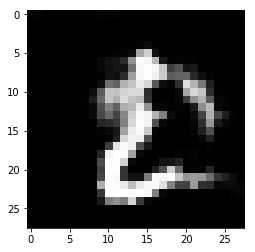

Epoch 1/2... Discriminator Loss: 1.1428... Generator Loss: 0.8241
Epoch 1/2... Discriminator Loss: 1.1041... Generator Loss: 1.2306
Epoch 1/2... Discriminator Loss: 0.8280... Generator Loss: 1.1794
Epoch 1/2... Discriminator Loss: 0.8637... Generator Loss: 0.9395
Epoch 1/2... Discriminator Loss: 1.1492... Generator Loss: 2.2481


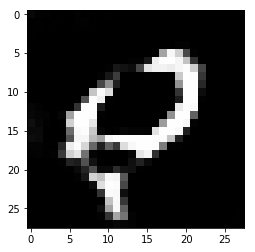

Epoch 1/2... Discriminator Loss: 1.1550... Generator Loss: 1.3985
Epoch 1/2... Discriminator Loss: 1.5227... Generator Loss: 2.3082
Epoch 1/2... Discriminator Loss: 1.4277... Generator Loss: 0.9163
Epoch 1/2... Discriminator Loss: 0.8259... Generator Loss: 1.8462
Epoch 1/2... Discriminator Loss: 0.8492... Generator Loss: 1.8946


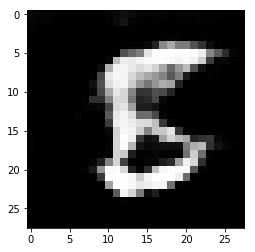

Epoch 1/2... Discriminator Loss: 0.9641... Generator Loss: 0.7994
Epoch 1/2... Discriminator Loss: 1.0889... Generator Loss: 1.2416
Epoch 1/2... Discriminator Loss: 0.9737... Generator Loss: 0.8495
Epoch 1/2... Discriminator Loss: 1.6264... Generator Loss: 0.3583
Epoch 1/2... Discriminator Loss: 0.9072... Generator Loss: 1.3629


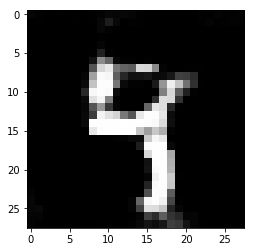

Epoch 1/2... Discriminator Loss: 1.0624... Generator Loss: 1.8894
Epoch 2/2... Discriminator Loss: 1.2657... Generator Loss: 0.5281
Epoch 2/2... Discriminator Loss: 1.0929... Generator Loss: 0.7808
Epoch 2/2... Discriminator Loss: 0.9593... Generator Loss: 0.9468
Epoch 2/2... Discriminator Loss: 1.8385... Generator Loss: 0.2279


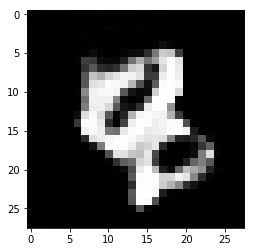

Epoch 2/2... Discriminator Loss: 0.7532... Generator Loss: 1.0760
Epoch 2/2... Discriminator Loss: 1.0612... Generator Loss: 1.0000
Epoch 2/2... Discriminator Loss: 1.0127... Generator Loss: 2.4474
Epoch 2/2... Discriminator Loss: 1.0947... Generator Loss: 1.4125
Epoch 2/2... Discriminator Loss: 1.3837... Generator Loss: 0.3998


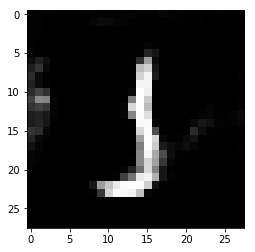

Epoch 2/2... Discriminator Loss: 0.7960... Generator Loss: 1.0539
Epoch 2/2... Discriminator Loss: 2.0187... Generator Loss: 0.2646
Epoch 2/2... Discriminator Loss: 1.4420... Generator Loss: 3.3250
Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 1.8062
Epoch 2/2... Discriminator Loss: 0.6589... Generator Loss: 1.2745


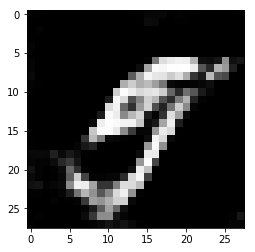

Epoch 2/2... Discriminator Loss: 1.9882... Generator Loss: 0.2539
Epoch 2/2... Discriminator Loss: 0.8071... Generator Loss: 1.4576
Epoch 2/2... Discriminator Loss: 1.3988... Generator Loss: 0.5921
Epoch 2/2... Discriminator Loss: 1.2932... Generator Loss: 1.5042
Epoch 2/2... Discriminator Loss: 1.0015... Generator Loss: 1.9028


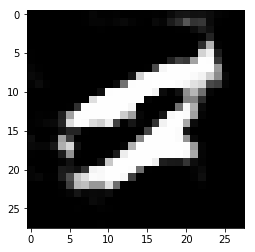

Epoch 2/2... Discriminator Loss: 1.1229... Generator Loss: 0.8122
Epoch 2/2... Discriminator Loss: 0.9046... Generator Loss: 2.4547
Epoch 2/2... Discriminator Loss: 1.5089... Generator Loss: 0.4552
Epoch 2/2... Discriminator Loss: 1.0448... Generator Loss: 1.2458
Epoch 2/2... Discriminator Loss: 0.9447... Generator Loss: 1.8554


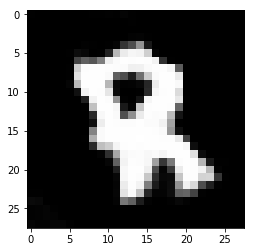

Epoch 2/2... Discriminator Loss: 0.8693... Generator Loss: 1.1899
Epoch 2/2... Discriminator Loss: 1.3042... Generator Loss: 1.7626
Epoch 2/2... Discriminator Loss: 0.7345... Generator Loss: 1.8387
Epoch 2/2... Discriminator Loss: 1.9315... Generator Loss: 0.3353
Epoch 2/2... Discriminator Loss: 0.6371... Generator Loss: 1.7693


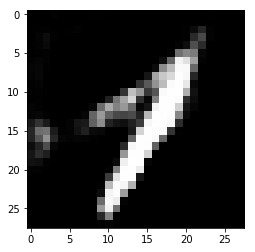

Epoch 2/2... Discriminator Loss: 0.6731... Generator Loss: 1.6910
Epoch 2/2... Discriminator Loss: 0.6968... Generator Loss: 1.5066
Epoch 2/2... Discriminator Loss: 3.0036... Generator Loss: 0.1174
Epoch 2/2... Discriminator Loss: 0.9522... Generator Loss: 0.7405
Epoch 2/2... Discriminator Loss: 1.1092... Generator Loss: 0.7498


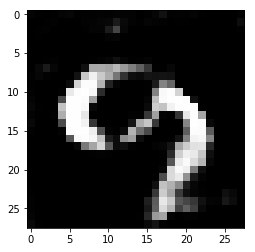

Epoch 2/2... Discriminator Loss: 1.6469... Generator Loss: 3.5817
Epoch 2/2... Discriminator Loss: 1.3693... Generator Loss: 0.5111
Epoch 2/2... Discriminator Loss: 0.3155... Generator Loss: 2.0550
Epoch 2/2... Discriminator Loss: 1.1720... Generator Loss: 0.6432
Epoch 2/2... Discriminator Loss: 2.3532... Generator Loss: 0.1726


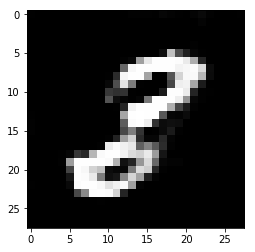

Epoch 2/2... Discriminator Loss: 1.0460... Generator Loss: 0.7566
Epoch 2/2... Discriminator Loss: 1.1259... Generator Loss: 3.0054
Epoch 2/2... Discriminator Loss: 0.6809... Generator Loss: 1.3118
Epoch 2/2... Discriminator Loss: 0.8172... Generator Loss: 1.8515
Epoch 2/2... Discriminator Loss: 1.2076... Generator Loss: 0.7550


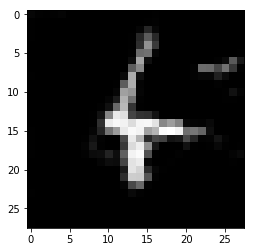

Epoch 2/2... Discriminator Loss: 1.7714... Generator Loss: 0.2769
Epoch 2/2... Discriminator Loss: 0.5971... Generator Loss: 1.4770
Epoch 2/2... Discriminator Loss: 2.0411... Generator Loss: 0.3447


In [154]:
#MNIST setting 1
#alpha = 0.2
batch_size = 64
z_dim = 128
learning_rate = 0.0025
beta1 = 0.5
losses = []


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses=train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

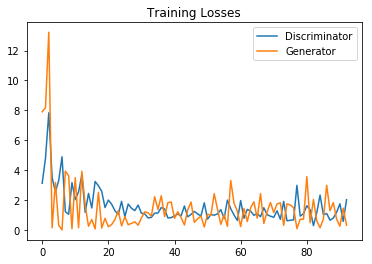

In [155]:
#MNIST setting 1 loss graph
fig, ax = pyplot.subplots()
losses = np.array(losses)
pyplot.plot(losses.T[0], label='Discriminator')
pyplot.plot(losses.T[1], label='Generator')
pyplot.title("Training Losses")
pyplot.legend()

Epoch 1/2... Discriminator Loss: 6.4047... Generator Loss: 1.3688
Epoch 1/2... Discriminator Loss: 11.7223... Generator Loss: 11.4612
Epoch 1/2... Discriminator Loss: 4.7898... Generator Loss: 2.0598
Epoch 1/2... Discriminator Loss: 5.2161... Generator Loss: 0.2626
Epoch 1/2... Discriminator Loss: 6.0724... Generator Loss: 3.0096


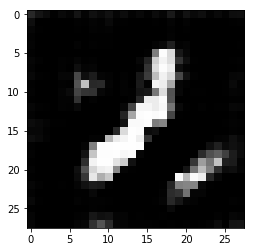

Epoch 1/2... Discriminator Loss: 4.5478... Generator Loss: 0.8804
Epoch 1/2... Discriminator Loss: 5.2773... Generator Loss: 0.0553
Epoch 1/2... Discriminator Loss: 5.0958... Generator Loss: 0.0580
Epoch 1/2... Discriminator Loss: 4.7139... Generator Loss: 1.6228
Epoch 1/2... Discriminator Loss: 0.6834... Generator Loss: 1.8971


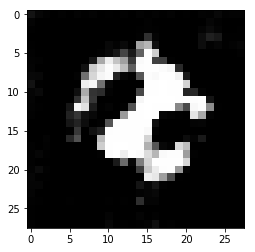

Epoch 1/2... Discriminator Loss: 1.5186... Generator Loss: 0.8409
Epoch 1/2... Discriminator Loss: 6.9092... Generator Loss: 10.5073
Epoch 1/2... Discriminator Loss: 2.0245... Generator Loss: 2.3074
Epoch 1/2... Discriminator Loss: 2.8511... Generator Loss: 1.4787
Epoch 1/2... Discriminator Loss: 4.1848... Generator Loss: 6.6430


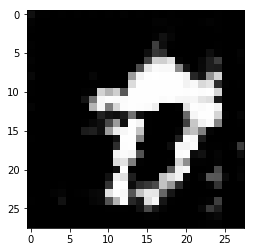

Epoch 1/2... Discriminator Loss: 4.5892... Generator Loss: 4.7279
Epoch 1/2... Discriminator Loss: 1.9582... Generator Loss: 1.6830
Epoch 1/2... Discriminator Loss: 0.2970... Generator Loss: 3.0070
Epoch 1/2... Discriminator Loss: 3.6105... Generator Loss: 0.4954
Epoch 1/2... Discriminator Loss: 3.0170... Generator Loss: 1.8471


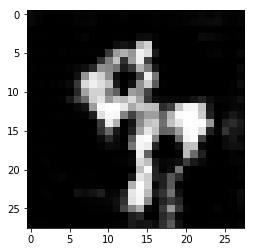

Epoch 1/2... Discriminator Loss: 3.5382... Generator Loss: 0.0988
Epoch 1/2... Discriminator Loss: 3.4881... Generator Loss: 1.0785
Epoch 1/2... Discriminator Loss: 1.3319... Generator Loss: 1.7318
Epoch 1/2... Discriminator Loss: 1.9871... Generator Loss: 2.0073
Epoch 1/2... Discriminator Loss: 3.2117... Generator Loss: 0.3018


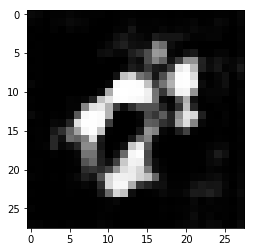

Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 2.2802
Epoch 1/2... Discriminator Loss: 2.1480... Generator Loss: 0.2291
Epoch 1/2... Discriminator Loss: 2.8555... Generator Loss: 0.1415
Epoch 1/2... Discriminator Loss: 1.1378... Generator Loss: 0.6249
Epoch 1/2... Discriminator Loss: 1.0046... Generator Loss: 2.1139


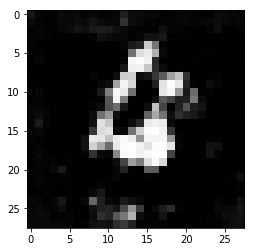

Epoch 1/2... Discriminator Loss: 1.1170... Generator Loss: 2.1188
Epoch 1/2... Discriminator Loss: 1.4322... Generator Loss: 0.5375
Epoch 1/2... Discriminator Loss: 2.1996... Generator Loss: 0.2021
Epoch 1/2... Discriminator Loss: 0.9537... Generator Loss: 1.8577
Epoch 1/2... Discriminator Loss: 1.0297... Generator Loss: 1.6645


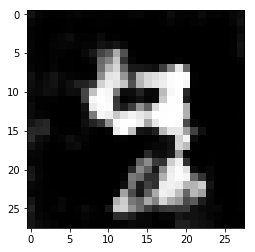

Epoch 1/2... Discriminator Loss: 2.4319... Generator Loss: 0.1581
Epoch 1/2... Discriminator Loss: 1.7495... Generator Loss: 2.7316
Epoch 1/2... Discriminator Loss: 1.1357... Generator Loss: 1.7610
Epoch 1/2... Discriminator Loss: 1.2741... Generator Loss: 0.6218
Epoch 1/2... Discriminator Loss: 1.6587... Generator Loss: 1.6832


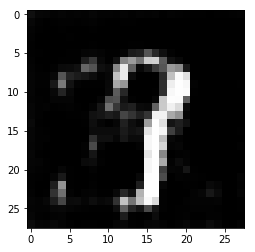

Epoch 1/2... Discriminator Loss: 1.3371... Generator Loss: 0.5745
Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 2.0929
Epoch 1/2... Discriminator Loss: 1.2186... Generator Loss: 2.3875
Epoch 1/2... Discriminator Loss: 1.3007... Generator Loss: 0.6359
Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 0.7872


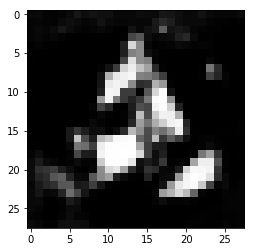

Epoch 1/2... Discriminator Loss: 1.0143... Generator Loss: 0.8903
Epoch 2/2... Discriminator Loss: 1.3284... Generator Loss: 0.6354
Epoch 2/2... Discriminator Loss: 1.6532... Generator Loss: 3.0160
Epoch 2/2... Discriminator Loss: 1.7997... Generator Loss: 2.8530
Epoch 2/2... Discriminator Loss: 1.3385... Generator Loss: 0.5360


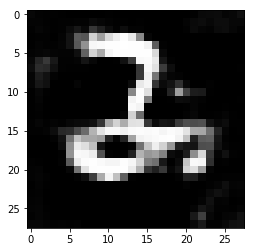

Epoch 2/2... Discriminator Loss: 1.8313... Generator Loss: 0.3556
Epoch 2/2... Discriminator Loss: 2.1476... Generator Loss: 0.2637
Epoch 2/2... Discriminator Loss: 1.3511... Generator Loss: 0.5142
Epoch 2/2... Discriminator Loss: 1.0752... Generator Loss: 1.2983
Epoch 2/2... Discriminator Loss: 1.2289... Generator Loss: 0.9515


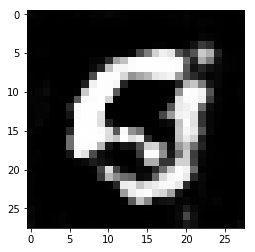

Epoch 2/2... Discriminator Loss: 1.2268... Generator Loss: 0.4995
Epoch 2/2... Discriminator Loss: 1.5284... Generator Loss: 2.4426
Epoch 2/2... Discriminator Loss: 1.3795... Generator Loss: 0.4892
Epoch 2/2... Discriminator Loss: 1.1641... Generator Loss: 1.9327
Epoch 2/2... Discriminator Loss: 1.3562... Generator Loss: 0.4547


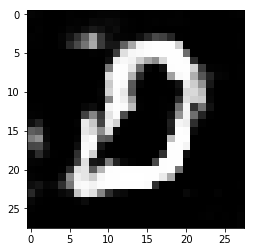

Epoch 2/2... Discriminator Loss: 1.6259... Generator Loss: 0.3547
Epoch 2/2... Discriminator Loss: 1.0882... Generator Loss: 1.6911
Epoch 2/2... Discriminator Loss: 1.0563... Generator Loss: 0.6869
Epoch 2/2... Discriminator Loss: 1.2454... Generator Loss: 1.6291
Epoch 2/2... Discriminator Loss: 1.4516... Generator Loss: 0.5254


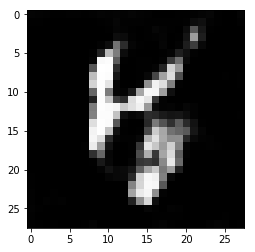

Epoch 2/2... Discriminator Loss: 1.0017... Generator Loss: 0.8528
Epoch 2/2... Discriminator Loss: 1.2755... Generator Loss: 0.7075
Epoch 2/2... Discriminator Loss: 2.1561... Generator Loss: 0.2066
Epoch 2/2... Discriminator Loss: 1.1464... Generator Loss: 0.5120
Epoch 2/2... Discriminator Loss: 1.2522... Generator Loss: 0.4684


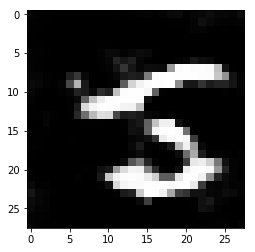

Epoch 2/2... Discriminator Loss: 1.0075... Generator Loss: 0.9502
Epoch 2/2... Discriminator Loss: 2.0347... Generator Loss: 0.2527
Epoch 2/2... Discriminator Loss: 1.2635... Generator Loss: 0.5208
Epoch 2/2... Discriminator Loss: 1.6960... Generator Loss: 0.3772
Epoch 2/2... Discriminator Loss: 0.7752... Generator Loss: 2.1775


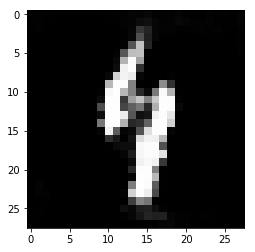

Epoch 2/2... Discriminator Loss: 0.7766... Generator Loss: 1.4587
Epoch 2/2... Discriminator Loss: 1.2686... Generator Loss: 0.4668
Epoch 2/2... Discriminator Loss: 0.9954... Generator Loss: 0.7854
Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 1.7472
Epoch 2/2... Discriminator Loss: 1.4616... Generator Loss: 0.5189


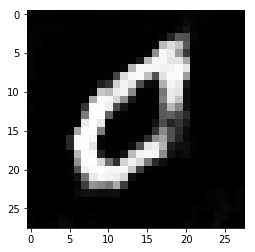

Epoch 2/2... Discriminator Loss: 1.9664... Generator Loss: 0.1890
Epoch 2/2... Discriminator Loss: 0.7924... Generator Loss: 1.0677
Epoch 2/2... Discriminator Loss: 0.8490... Generator Loss: 1.1443
Epoch 2/2... Discriminator Loss: 1.0844... Generator Loss: 0.5416
Epoch 2/2... Discriminator Loss: 2.1468... Generator Loss: 2.5391


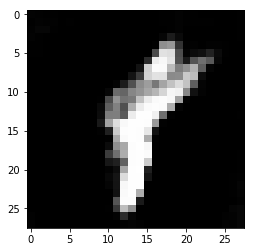

Epoch 2/2... Discriminator Loss: 0.7730... Generator Loss: 1.3984
Epoch 2/2... Discriminator Loss: 0.8709... Generator Loss: 1.0791
Epoch 2/2... Discriminator Loss: 1.1506... Generator Loss: 0.6801
Epoch 2/2... Discriminator Loss: 1.0679... Generator Loss: 1.5762
Epoch 2/2... Discriminator Loss: 2.0235... Generator Loss: 0.2783


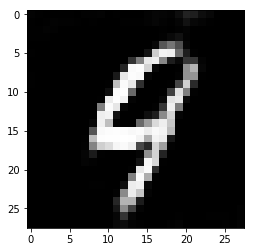

Epoch 2/2... Discriminator Loss: 1.0935... Generator Loss: 0.5501
Epoch 2/2... Discriminator Loss: 1.7092... Generator Loss: 3.6858
Epoch 2/2... Discriminator Loss: 0.8030... Generator Loss: 2.0926


In [136]:
#MNIST setting 2
#alpha = 0.5
batch_size = 64
z_dim = 128
learning_rate = 0.0025
beta1 = 0.3
losses = []


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses=train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

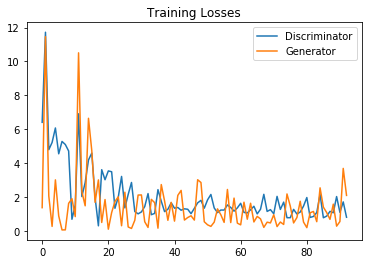

In [137]:
#MNIST setting 2 loss graph
fig, ax = pyplot.subplots()
losses = np.array(losses)
pyplot.plot(losses.T[0], label='Discriminator')
pyplot.plot(losses.T[1], label='Generator')
pyplot.title("Training Losses")
pyplot.legend()

Epoch 1/2... Discriminator Loss: 22.8647... Generator Loss: 0.3954
Epoch 1/2... Discriminator Loss: 2.2611... Generator Loss: 5.6241
Epoch 1/2... Discriminator Loss: 2.3178... Generator Loss: 14.7121
Epoch 1/2... Discriminator Loss: 5.4871... Generator Loss: 12.0332
Epoch 1/2... Discriminator Loss: 7.3558... Generator Loss: 10.5364


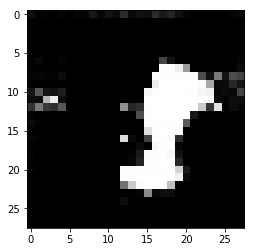

Epoch 1/2... Discriminator Loss: 1.2640... Generator Loss: 5.6919
Epoch 1/2... Discriminator Loss: 1.2594... Generator Loss: 9.6746
Epoch 1/2... Discriminator Loss: 6.1894... Generator Loss: 0.4211
Epoch 1/2... Discriminator Loss: 4.0164... Generator Loss: 9.9889
Epoch 1/2... Discriminator Loss: 1.4280... Generator Loss: 3.3380


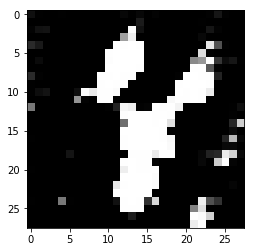

Epoch 1/2... Discriminator Loss: 3.3035... Generator Loss: 1.0290
Epoch 1/2... Discriminator Loss: 0.6573... Generator Loss: 5.2972
Epoch 1/2... Discriminator Loss: 6.9580... Generator Loss: 17.4109
Epoch 1/2... Discriminator Loss: 2.4550... Generator Loss: 4.6660
Epoch 1/2... Discriminator Loss: 6.4315... Generator Loss: 0.4817


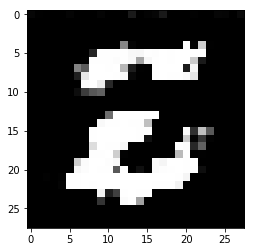

Epoch 1/2... Discriminator Loss: 0.8221... Generator Loss: 5.9070
Epoch 1/2... Discriminator Loss: 4.6534... Generator Loss: 0.8184
Epoch 1/2... Discriminator Loss: 6.7975... Generator Loss: 0.2435
Epoch 1/2... Discriminator Loss: 0.0235... Generator Loss: 6.6835
Epoch 1/2... Discriminator Loss: 9.0472... Generator Loss: 0.0042


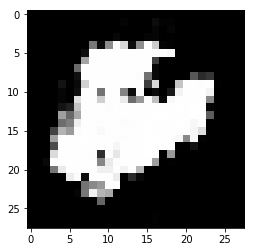

Epoch 1/2... Discriminator Loss: 5.0030... Generator Loss: 11.9402
Epoch 1/2... Discriminator Loss: 0.1578... Generator Loss: 9.3214
Epoch 1/2... Discriminator Loss: 3.9818... Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 1.7784... Generator Loss: 1.3620
Epoch 1/2... Discriminator Loss: 1.8502... Generator Loss: 1.2301


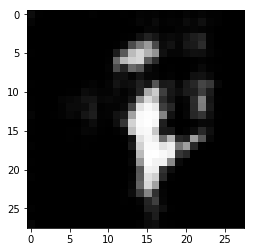

Epoch 1/2... Discriminator Loss: 1.7632... Generator Loss: 1.3304
Epoch 1/2... Discriminator Loss: 1.5987... Generator Loss: 0.8477
Epoch 1/2... Discriminator Loss: 1.2766... Generator Loss: 1.5301
Epoch 1/2... Discriminator Loss: 0.9996... Generator Loss: 1.4615
Epoch 1/2... Discriminator Loss: 1.0944... Generator Loss: 1.0588


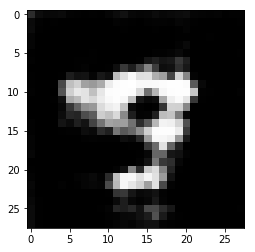

Epoch 1/2... Discriminator Loss: 1.0687... Generator Loss: 1.1058
Epoch 1/2... Discriminator Loss: 2.0006... Generator Loss: 4.6669
Epoch 1/2... Discriminator Loss: 1.6003... Generator Loss: 0.7148
Epoch 1/2... Discriminator Loss: 1.5518... Generator Loss: 0.7533
Epoch 1/2... Discriminator Loss: 2.1295... Generator Loss: 0.4508


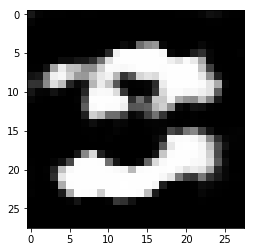

Epoch 1/2... Discriminator Loss: 1.9229... Generator Loss: 2.0106
Epoch 1/2... Discriminator Loss: 1.0389... Generator Loss: 2.6744
Epoch 1/2... Discriminator Loss: 0.6553... Generator Loss: 2.0385
Epoch 1/2... Discriminator Loss: 1.5949... Generator Loss: 0.6889
Epoch 1/2... Discriminator Loss: 0.5850... Generator Loss: 2.0795


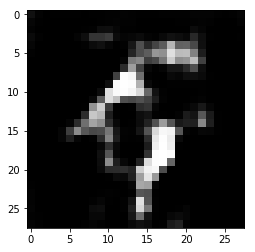

Epoch 1/2... Discriminator Loss: 0.6249... Generator Loss: 1.2808
Epoch 1/2... Discriminator Loss: 1.5030... Generator Loss: 3.8288
Epoch 1/2... Discriminator Loss: 1.7965... Generator Loss: 4.0951
Epoch 1/2... Discriminator Loss: 0.7263... Generator Loss: 1.5567
Epoch 1/2... Discriminator Loss: 1.5329... Generator Loss: 0.4432


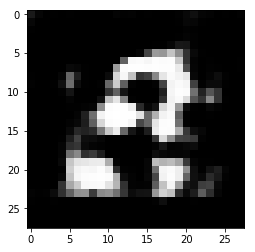

Epoch 1/2... Discriminator Loss: 1.0757... Generator Loss: 1.5797
Epoch 2/2... Discriminator Loss: 1.1212... Generator Loss: 2.4915
Epoch 2/2... Discriminator Loss: 0.7539... Generator Loss: 2.2915
Epoch 2/2... Discriminator Loss: 2.3750... Generator Loss: 4.3690
Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 1.2446


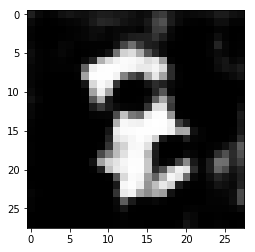

Epoch 2/2... Discriminator Loss: 1.4092... Generator Loss: 0.7172
Epoch 2/2... Discriminator Loss: 0.8199... Generator Loss: 1.4975
Epoch 2/2... Discriminator Loss: 1.0088... Generator Loss: 2.7334
Epoch 2/2... Discriminator Loss: 0.6790... Generator Loss: 3.1373
Epoch 2/2... Discriminator Loss: 1.0774... Generator Loss: 1.1866


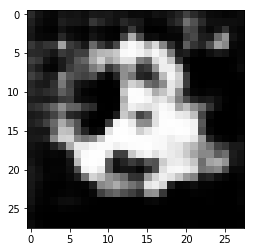

Epoch 2/2... Discriminator Loss: 2.3771... Generator Loss: 4.4901
Epoch 2/2... Discriminator Loss: 1.2691... Generator Loss: 0.4239
Epoch 2/2... Discriminator Loss: 1.9395... Generator Loss: 0.2433
Epoch 2/2... Discriminator Loss: 1.5048... Generator Loss: 1.1410
Epoch 2/2... Discriminator Loss: 1.4626... Generator Loss: 0.5004


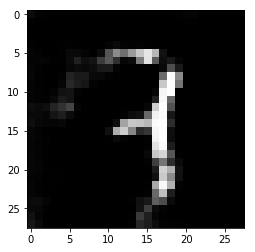

Epoch 2/2... Discriminator Loss: 1.1493... Generator Loss: 0.6878
Epoch 2/2... Discriminator Loss: 1.0397... Generator Loss: 2.4548
Epoch 2/2... Discriminator Loss: 1.4580... Generator Loss: 0.4753
Epoch 2/2... Discriminator Loss: 0.9870... Generator Loss: 2.3012
Epoch 2/2... Discriminator Loss: 1.4548... Generator Loss: 0.5247


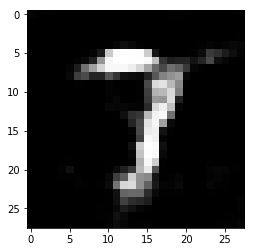

Epoch 2/2... Discriminator Loss: 1.5713... Generator Loss: 0.4902
Epoch 2/2... Discriminator Loss: 1.0539... Generator Loss: 2.0548
Epoch 2/2... Discriminator Loss: 1.2920... Generator Loss: 1.9423
Epoch 2/2... Discriminator Loss: 1.2790... Generator Loss: 0.5853
Epoch 2/2... Discriminator Loss: 1.4462... Generator Loss: 3.3000


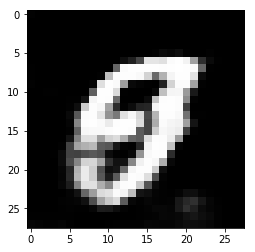

Epoch 2/2... Discriminator Loss: 1.2654... Generator Loss: 0.6186
Epoch 2/2... Discriminator Loss: 1.2812... Generator Loss: 0.4915
Epoch 2/2... Discriminator Loss: 1.0945... Generator Loss: 0.5518
Epoch 2/2... Discriminator Loss: 0.9498... Generator Loss: 1.5002
Epoch 2/2... Discriminator Loss: 1.7387... Generator Loss: 3.6639


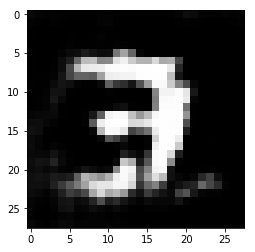

Epoch 2/2... Discriminator Loss: 1.2927... Generator Loss: 0.4935
Epoch 2/2... Discriminator Loss: 1.3409... Generator Loss: 0.6530
Epoch 2/2... Discriminator Loss: 1.2625... Generator Loss: 0.5133
Epoch 2/2... Discriminator Loss: 1.3738... Generator Loss: 0.6979
Epoch 2/2... Discriminator Loss: 1.3199... Generator Loss: 0.8190


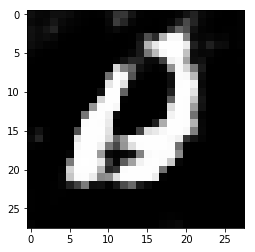

Epoch 2/2... Discriminator Loss: 1.0406... Generator Loss: 0.6130
Epoch 2/2... Discriminator Loss: 1.1907... Generator Loss: 0.6745
Epoch 2/2... Discriminator Loss: 1.1298... Generator Loss: 0.7026
Epoch 2/2... Discriminator Loss: 1.2578... Generator Loss: 0.6173
Epoch 2/2... Discriminator Loss: 0.7363... Generator Loss: 2.3766


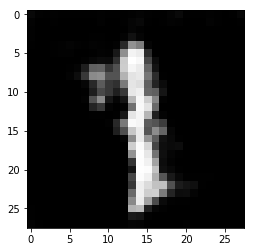

Epoch 2/2... Discriminator Loss: 1.4239... Generator Loss: 0.5660
Epoch 2/2... Discriminator Loss: 1.3984... Generator Loss: 0.4673
Epoch 2/2... Discriminator Loss: 1.6390... Generator Loss: 2.7338
Epoch 2/2... Discriminator Loss: 1.0667... Generator Loss: 1.9705
Epoch 2/2... Discriminator Loss: 1.0834... Generator Loss: 1.9974


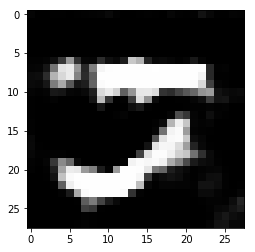

Epoch 2/2... Discriminator Loss: 1.4179... Generator Loss: 0.3857
Epoch 2/2... Discriminator Loss: 0.9286... Generator Loss: 1.3736
Epoch 2/2... Discriminator Loss: 0.7799... Generator Loss: 1.3375


In [134]:
#MNIST setting 3
batch_size = 64
z_dim = 128
learning_rate = 0.005
beta1 = 0.5
losses = []

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses=train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

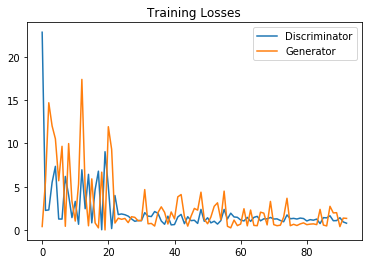

In [135]:
#MNIST setting 3 loss graph
fig, ax = pyplot.subplots()
losses = np.array(losses)
pyplot.plot(losses.T[0], label='Discriminator')
pyplot.plot(losses.T[1], label='Generator')
pyplot.title("Training Losses")
pyplot.legend()

Epoch 1/2... Discriminator Loss: 0.4929... Generator Loss: 8.2732
Epoch 1/2... Discriminator Loss: 1.0732... Generator Loss: 9.7686
Epoch 1/2... Discriminator Loss: 0.0444... Generator Loss: 8.1910
Epoch 1/2... Discriminator Loss: 9.7659... Generator Loss: 2.5109
Epoch 1/2... Discriminator Loss: 6.5596... Generator Loss: 1.5000


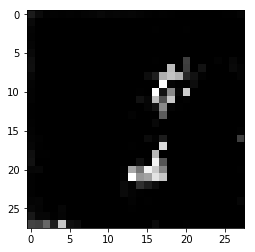

Epoch 1/2... Discriminator Loss: 0.5059... Generator Loss: 5.2177
Epoch 1/2... Discriminator Loss: 7.4529... Generator Loss: 16.8040
Epoch 1/2... Discriminator Loss: 1.3646... Generator Loss: 4.5052
Epoch 1/2... Discriminator Loss: 2.3670... Generator Loss: 2.4806
Epoch 1/2... Discriminator Loss: 1.8360... Generator Loss: 6.0038


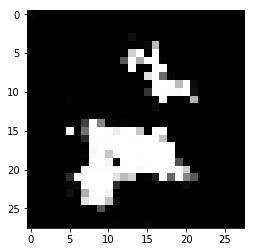

Epoch 1/2... Discriminator Loss: 2.0376... Generator Loss: 8.5061
Epoch 1/2... Discriminator Loss: 1.0130... Generator Loss: 2.6657
Epoch 1/2... Discriminator Loss: 1.8816... Generator Loss: 8.9273
Epoch 1/2... Discriminator Loss: 0.3053... Generator Loss: 5.2888
Epoch 1/2... Discriminator Loss: 0.1768... Generator Loss: 3.4474


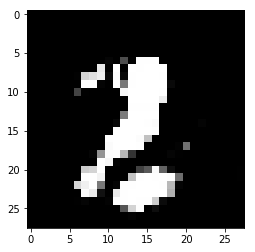

Epoch 1/2... Discriminator Loss: 2.1828... Generator Loss: 1.1872
Epoch 1/2... Discriminator Loss: 0.5692... Generator Loss: 3.3765
Epoch 1/2... Discriminator Loss: 0.2870... Generator Loss: 3.8591
Epoch 1/2... Discriminator Loss: 0.8818... Generator Loss: 1.8143
Epoch 1/2... Discriminator Loss: 0.4229... Generator Loss: 7.6888


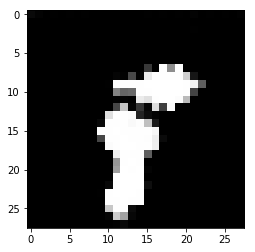

Epoch 1/2... Discriminator Loss: 2.7267... Generator Loss: 3.6315
Epoch 1/2... Discriminator Loss: 3.0130... Generator Loss: 0.4581
Epoch 1/2... Discriminator Loss: 2.1317... Generator Loss: 8.2726
Epoch 1/2... Discriminator Loss: 0.9246... Generator Loss: 1.2039
Epoch 1/2... Discriminator Loss: 3.9173... Generator Loss: 0.5489


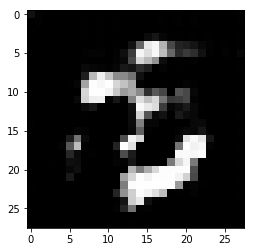

Epoch 1/2... Discriminator Loss: 2.9650... Generator Loss: 2.5486
Epoch 1/2... Discriminator Loss: 6.7911... Generator Loss: 3.5149
Epoch 1/2... Discriminator Loss: 7.7965... Generator Loss: 0.0574
Epoch 1/2... Discriminator Loss: 1.3646... Generator Loss: 2.0922
Epoch 1/2... Discriminator Loss: 1.0021... Generator Loss: 3.9744


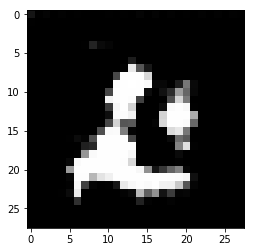

Epoch 1/2... Discriminator Loss: 0.6411... Generator Loss: 3.3161
Epoch 1/2... Discriminator Loss: 0.7875... Generator Loss: 2.1860
Epoch 1/2... Discriminator Loss: 1.8111... Generator Loss: 2.2725
Epoch 1/2... Discriminator Loss: 2.1329... Generator Loss: 7.9555
Epoch 1/2... Discriminator Loss: 1.4254... Generator Loss: 2.7004


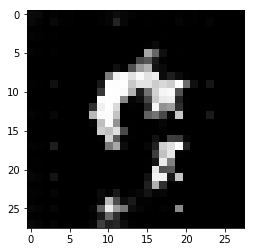

Epoch 1/2... Discriminator Loss: 2.4051... Generator Loss: 5.5440
Epoch 1/2... Discriminator Loss: 0.3853... Generator Loss: 3.9134
Epoch 1/2... Discriminator Loss: 1.3811... Generator Loss: 3.9150
Epoch 1/2... Discriminator Loss: 2.8895... Generator Loss: 7.3480
Epoch 1/2... Discriminator Loss: 0.4666... Generator Loss: 3.3424


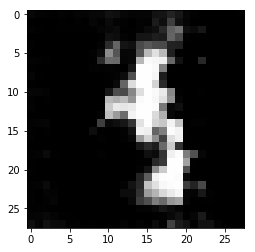

Epoch 1/2... Discriminator Loss: 1.8275... Generator Loss: 0.4789
Epoch 1/2... Discriminator Loss: 0.5178... Generator Loss: 3.7996
Epoch 1/2... Discriminator Loss: 0.8864... Generator Loss: 1.7479
Epoch 1/2... Discriminator Loss: 0.2724... Generator Loss: 2.7985
Epoch 1/2... Discriminator Loss: 0.7844... Generator Loss: 1.8157


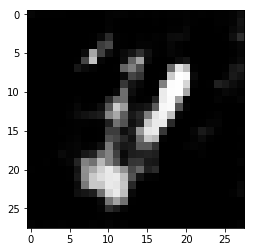

Epoch 1/2... Discriminator Loss: 1.1979... Generator Loss: 2.0934
Epoch 2/2... Discriminator Loss: 0.4966... Generator Loss: 2.8968
Epoch 2/2... Discriminator Loss: 1.1346... Generator Loss: 8.2453
Epoch 2/2... Discriminator Loss: 0.5497... Generator Loss: 5.2836
Epoch 2/2... Discriminator Loss: 1.2327... Generator Loss: 0.9348


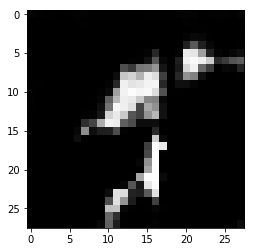

Epoch 2/2... Discriminator Loss: 0.2590... Generator Loss: 3.7296
Epoch 2/2... Discriminator Loss: 1.3703... Generator Loss: 1.3772
Epoch 2/2... Discriminator Loss: 0.5732... Generator Loss: 5.3680
Epoch 2/2... Discriminator Loss: 1.1379... Generator Loss: 1.2590
Epoch 2/2... Discriminator Loss: 0.8690... Generator Loss: 2.4630


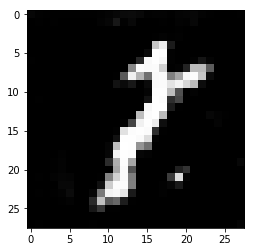

Epoch 2/2... Discriminator Loss: 0.4708... Generator Loss: 1.8406
Epoch 2/2... Discriminator Loss: 0.2842... Generator Loss: 3.7058
Epoch 2/2... Discriminator Loss: 0.4582... Generator Loss: 2.4449
Epoch 2/2... Discriminator Loss: 0.5946... Generator Loss: 1.8535
Epoch 2/2... Discriminator Loss: 0.1966... Generator Loss: 3.1277


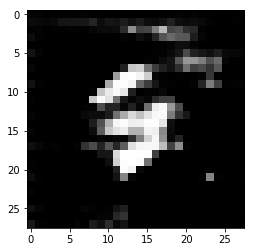

Epoch 2/2... Discriminator Loss: 0.2178... Generator Loss: 7.7710
Epoch 2/2... Discriminator Loss: 0.2616... Generator Loss: 4.3160
Epoch 2/2... Discriminator Loss: 1.2330... Generator Loss: 1.4813
Epoch 2/2... Discriminator Loss: 0.7123... Generator Loss: 2.4879
Epoch 2/2... Discriminator Loss: 0.9212... Generator Loss: 6.1065


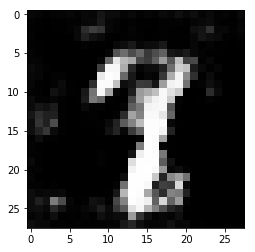

Epoch 2/2... Discriminator Loss: 0.3625... Generator Loss: 3.5946
Epoch 2/2... Discriminator Loss: 0.2320... Generator Loss: 4.6534
Epoch 2/2... Discriminator Loss: 0.5118... Generator Loss: 3.2221
Epoch 2/2... Discriminator Loss: 0.0643... Generator Loss: 6.4961
Epoch 2/2... Discriminator Loss: 0.2885... Generator Loss: 3.1052


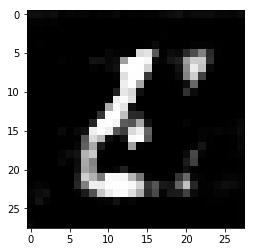

Epoch 2/2... Discriminator Loss: 0.2706... Generator Loss: 3.3361
Epoch 2/2... Discriminator Loss: 0.8940... Generator Loss: 2.2458
Epoch 2/2... Discriminator Loss: 0.4480... Generator Loss: 4.3514
Epoch 2/2... Discriminator Loss: 3.1829... Generator Loss: 0.4309
Epoch 2/2... Discriminator Loss: 0.4272... Generator Loss: 4.5203


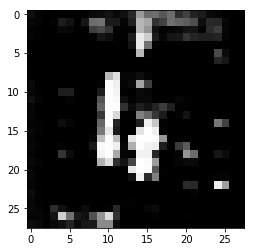

Epoch 2/2... Discriminator Loss: 0.7746... Generator Loss: 1.9051
Epoch 2/2... Discriminator Loss: 0.5965... Generator Loss: 6.8795
Epoch 2/2... Discriminator Loss: 0.3513... Generator Loss: 4.0618
Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 5.6042
Epoch 2/2... Discriminator Loss: 0.2819... Generator Loss: 4.4517


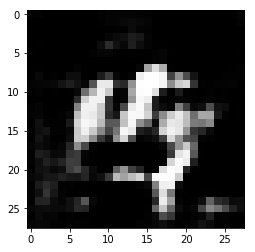

Epoch 2/2... Discriminator Loss: 0.2734... Generator Loss: 4.2892
Epoch 2/2... Discriminator Loss: 0.1819... Generator Loss: 4.9820
Epoch 2/2... Discriminator Loss: 0.7826... Generator Loss: 1.8784
Epoch 2/2... Discriminator Loss: 0.8038... Generator Loss: 5.4797
Epoch 2/2... Discriminator Loss: 0.4381... Generator Loss: 5.9414


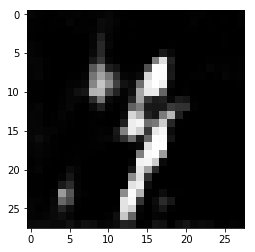

Epoch 2/2... Discriminator Loss: 0.4108... Generator Loss: 3.3301
Epoch 2/2... Discriminator Loss: 1.4796... Generator Loss: 1.4385
Epoch 2/2... Discriminator Loss: 0.8323... Generator Loss: 8.8786
Epoch 2/2... Discriminator Loss: 0.7273... Generator Loss: 1.9547
Epoch 2/2... Discriminator Loss: 0.2012... Generator Loss: 4.1236


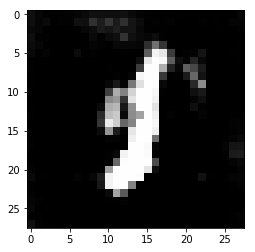

Epoch 2/2... Discriminator Loss: 0.3829... Generator Loss: 3.8205
Epoch 2/2... Discriminator Loss: 1.2179... Generator Loss: 4.9712
Epoch 2/2... Discriminator Loss: 0.3591... Generator Loss: 2.3514


In [142]:
#MNIST setting 4
batch_size = 64
z_dim = 128
learning_rate = 0.0025
beta1 = 0.7
losses = []

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses=train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

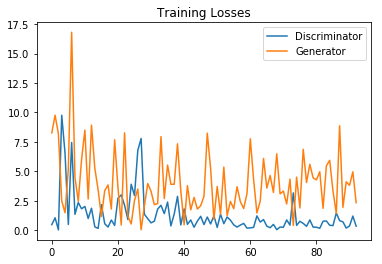

In [143]:
#MNIST setting 4 loss graph
fig, ax = pyplot.subplots()
losses = np.array(losses)
pyplot.plot(losses.T[0], label='Discriminator')
pyplot.plot(losses.T[1], label='Generator')
pyplot.title("Training Losses")
pyplot.legend()

Epoch 1/2... Discriminator Loss: 19.3116... Generator Loss: 0.1782
Epoch 1/2... Discriminator Loss: 5.6506... Generator Loss: 5.1748
Epoch 1/2... Discriminator Loss: 4.5588... Generator Loss: 1.5796
Epoch 1/2... Discriminator Loss: 7.0786... Generator Loss: 9.6442
Epoch 1/2... Discriminator Loss: 9.2667... Generator Loss: 0.1375


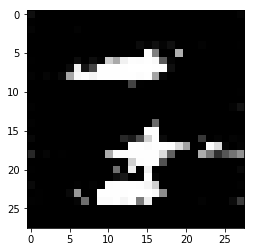

Epoch 1/2... Discriminator Loss: 9.5926... Generator Loss: 0.0051
Epoch 1/2... Discriminator Loss: 3.8454... Generator Loss: 1.3912
Epoch 1/2... Discriminator Loss: 2.5354... Generator Loss: 4.5998
Epoch 1/2... Discriminator Loss: 1.9941... Generator Loss: 6.4589
Epoch 1/2... Discriminator Loss: 2.8521... Generator Loss: 2.4926


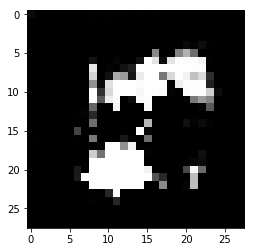

Epoch 1/2... Discriminator Loss: 3.3132... Generator Loss: 0.4201
Epoch 1/2... Discriminator Loss: 0.0189... Generator Loss: 7.5036
Epoch 1/2... Discriminator Loss: 1.5591... Generator Loss: 5.7352
Epoch 1/2... Discriminator Loss: 6.1380... Generator Loss: 0.0145
Epoch 1/2... Discriminator Loss: 0.3053... Generator Loss: 2.8389


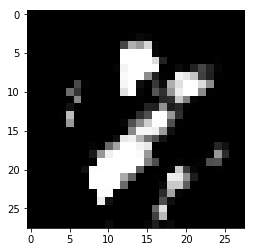

Epoch 1/2... Discriminator Loss: 8.8122... Generator Loss: 0.0022
Epoch 1/2... Discriminator Loss: 1.6390... Generator Loss: 2.0473
Epoch 1/2... Discriminator Loss: 3.6559... Generator Loss: 0.2226
Epoch 1/2... Discriminator Loss: 1.8034... Generator Loss: 1.7132
Epoch 1/2... Discriminator Loss: 4.4025... Generator Loss: 0.5145


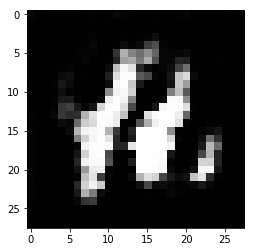

Epoch 1/2... Discriminator Loss: 4.0677... Generator Loss: 0.4808
Epoch 1/2... Discriminator Loss: 2.2707... Generator Loss: 1.5954
Epoch 1/2... Discriminator Loss: 1.7967... Generator Loss: 1.3406
Epoch 2/2... Discriminator Loss: 1.4786... Generator Loss: 0.5369
Epoch 2/2... Discriminator Loss: 1.1532... Generator Loss: 1.5818


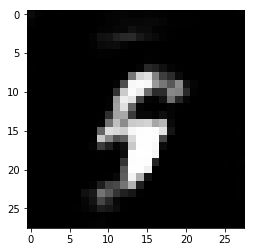

Epoch 2/2... Discriminator Loss: 1.9963... Generator Loss: 0.3577
Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 2.6437
Epoch 2/2... Discriminator Loss: 1.3224... Generator Loss: 2.7486
Epoch 2/2... Discriminator Loss: 2.5396... Generator Loss: 4.2123
Epoch 2/2... Discriminator Loss: 1.1660... Generator Loss: 0.7378


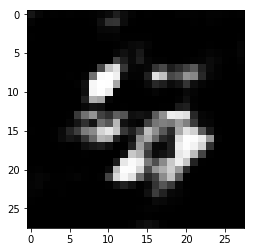

Epoch 2/2... Discriminator Loss: 1.5626... Generator Loss: 0.4794
Epoch 2/2... Discriminator Loss: 1.1472... Generator Loss: 0.6871
Epoch 2/2... Discriminator Loss: 0.9854... Generator Loss: 2.3432
Epoch 2/2... Discriminator Loss: 2.1502... Generator Loss: 0.2209
Epoch 2/2... Discriminator Loss: 0.8652... Generator Loss: 1.5039


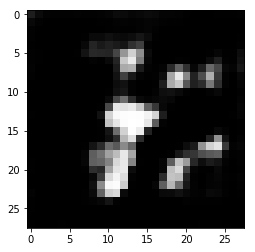

Epoch 2/2... Discriminator Loss: 1.0697... Generator Loss: 0.7965
Epoch 2/2... Discriminator Loss: 1.2247... Generator Loss: 1.7429
Epoch 2/2... Discriminator Loss: 1.4427... Generator Loss: 1.1729
Epoch 2/2... Discriminator Loss: 1.4471... Generator Loss: 1.9849
Epoch 2/2... Discriminator Loss: 1.2010... Generator Loss: 1.0183


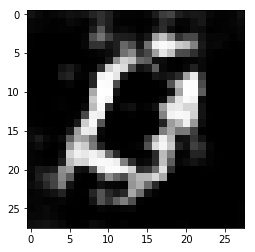

Epoch 2/2... Discriminator Loss: 1.2234... Generator Loss: 0.9719
Epoch 2/2... Discriminator Loss: 1.0898... Generator Loss: 1.2778
Epoch 2/2... Discriminator Loss: 1.6540... Generator Loss: 0.3449
Epoch 2/2... Discriminator Loss: 1.0856... Generator Loss: 1.2866
Epoch 2/2... Discriminator Loss: 1.3967... Generator Loss: 0.3950


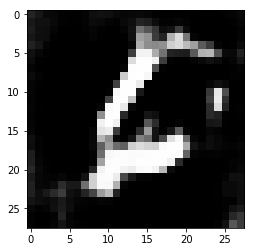

Epoch 2/2... Discriminator Loss: 1.8894... Generator Loss: 0.2160


In [138]:
#MNIST setting 5
batch_size = 128
z_dim = 256
learning_rate = 0.005
beta1 = 0.3
losses = []

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses=train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

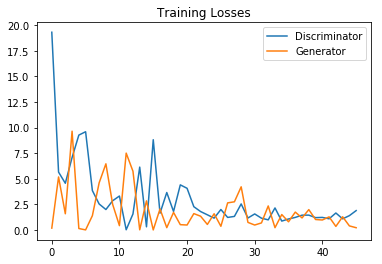

In [139]:
#MNIST setting 5 loss graph
fig, ax = pyplot.subplots()
losses = np.array(losses)
pyplot.plot(losses.T[0], label='Discriminator')
pyplot.plot(losses.T[1], label='Generator')
pyplot.title("Training Losses")
pyplot.legend()

Epoch 1/2... Discriminator Loss: 20.7277... Generator Loss: 35.4117
Epoch 1/2... Discriminator Loss: 13.0336... Generator Loss: 0.0237
Epoch 1/2... Discriminator Loss: 3.8488... Generator Loss: 0.4600
Epoch 1/2... Discriminator Loss: 0.8558... Generator Loss: 2.3868
Epoch 1/2... Discriminator Loss: 1.8148... Generator Loss: 2.9540


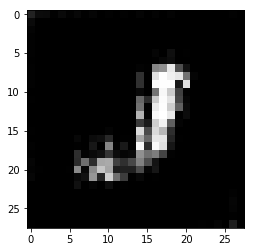

Epoch 1/2... Discriminator Loss: 1.6521... Generator Loss: 2.3735
Epoch 1/2... Discriminator Loss: 3.3399... Generator Loss: 0.2108
Epoch 1/2... Discriminator Loss: 1.5456... Generator Loss: 2.6446
Epoch 1/2... Discriminator Loss: 2.1992... Generator Loss: 0.5562
Epoch 1/2... Discriminator Loss: 2.4227... Generator Loss: 4.3412


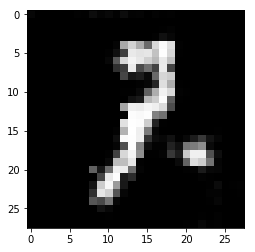

Epoch 1/2... Discriminator Loss: 0.7725... Generator Loss: 1.3882
Epoch 1/2... Discriminator Loss: 1.8047... Generator Loss: 0.5044
Epoch 1/2... Discriminator Loss: 1.7625... Generator Loss: 0.4472
Epoch 1/2... Discriminator Loss: 1.3990... Generator Loss: 1.4383
Epoch 1/2... Discriminator Loss: 0.8624... Generator Loss: 1.7482


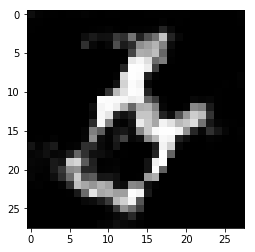

Epoch 1/2... Discriminator Loss: 1.0896... Generator Loss: 1.7349
Epoch 1/2... Discriminator Loss: 1.7411... Generator Loss: 0.4042
Epoch 1/2... Discriminator Loss: 3.6157... Generator Loss: 6.3058
Epoch 1/2... Discriminator Loss: 1.4433... Generator Loss: 2.5757
Epoch 1/2... Discriminator Loss: 1.2665... Generator Loss: 0.7887


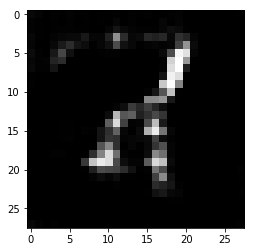

Epoch 1/2... Discriminator Loss: 1.8408... Generator Loss: 0.3525
Epoch 1/2... Discriminator Loss: 1.1513... Generator Loss: 1.1912
Epoch 1/2... Discriminator Loss: 0.9181... Generator Loss: 0.8736
Epoch 2/2... Discriminator Loss: 1.3920... Generator Loss: 0.8474
Epoch 2/2... Discriminator Loss: 1.1048... Generator Loss: 1.4832


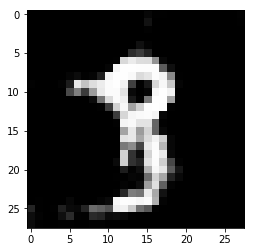

Epoch 2/2... Discriminator Loss: 2.0493... Generator Loss: 0.3525
Epoch 2/2... Discriminator Loss: 0.9335... Generator Loss: 2.2933
Epoch 2/2... Discriminator Loss: 0.9498... Generator Loss: 1.1457
Epoch 2/2... Discriminator Loss: 1.2716... Generator Loss: 1.0792
Epoch 2/2... Discriminator Loss: 1.3450... Generator Loss: 2.7321


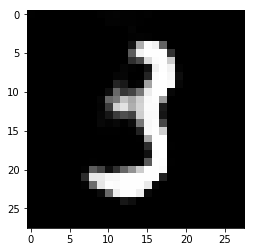

Epoch 2/2... Discriminator Loss: 2.1460... Generator Loss: 4.3119
Epoch 2/2... Discriminator Loss: 0.9074... Generator Loss: 1.9176
Epoch 2/2... Discriminator Loss: 0.5047... Generator Loss: 1.8091
Epoch 2/2... Discriminator Loss: 0.9262... Generator Loss: 1.1902
Epoch 2/2... Discriminator Loss: 0.8533... Generator Loss: 1.4961


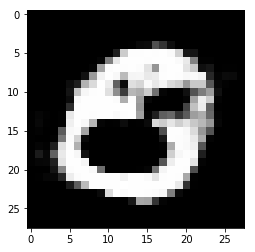

Epoch 2/2... Discriminator Loss: 1.3669... Generator Loss: 0.4983
Epoch 2/2... Discriminator Loss: 2.1436... Generator Loss: 4.3533
Epoch 2/2... Discriminator Loss: 1.9666... Generator Loss: 0.4321
Epoch 2/2... Discriminator Loss: 1.1020... Generator Loss: 0.9303
Epoch 2/2... Discriminator Loss: 1.0700... Generator Loss: 1.4685


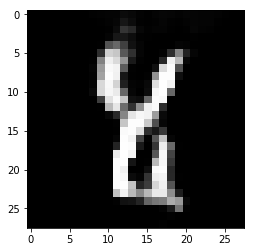

Epoch 2/2... Discriminator Loss: 0.7968... Generator Loss: 1.2623
Epoch 2/2... Discriminator Loss: 0.8390... Generator Loss: 2.1902
Epoch 2/2... Discriminator Loss: 1.2343... Generator Loss: 0.7333
Epoch 2/2... Discriminator Loss: 0.9700... Generator Loss: 1.0472
Epoch 2/2... Discriminator Loss: 1.7440... Generator Loss: 0.4807


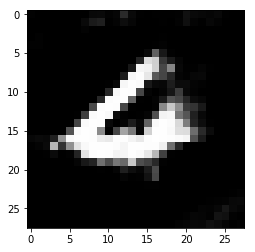

Epoch 2/2... Discriminator Loss: 1.3521... Generator Loss: 0.5418


In [156]:
#MNIST setting 6
batch_size = 128
z_dim = 128
learning_rate = 0.005
beta1 = 0.5
losses = []

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses=train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

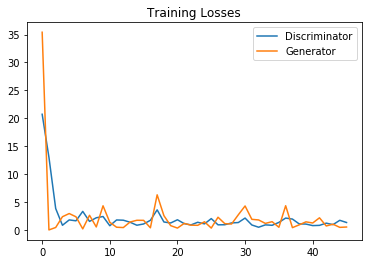

In [157]:
#MNIST setting 6 loss graph
fig, ax = pyplot.subplots()
losses = np.array(losses)
pyplot.plot(losses.T[0], label='Discriminator')
pyplot.plot(losses.T[1], label='Generator')
pyplot.title("Training Losses")
pyplot.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.2815... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 0.1013... Generator Loss: 6.7738
Epoch 1/1... Discriminator Loss: 3.0728... Generator Loss: 0.2078
Epoch 1/1... Discriminator Loss: 0.3589... Generator Loss: 3.1616
Epoch 1/1... Discriminator Loss: 0.2279... Generator Loss: 9.2724


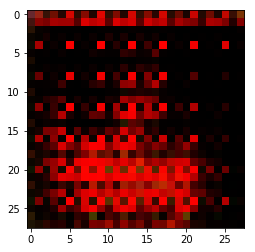

Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 6.8600
Epoch 1/1... Discriminator Loss: 0.5987... Generator Loss: 1.6293
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 1.4777
Epoch 1/1... Discriminator Loss: 5.6352... Generator Loss: 0.0204
Epoch 1/1... Discriminator Loss: 3.3441... Generator Loss: 0.3353


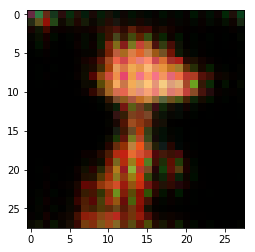

Epoch 1/1... Discriminator Loss: 1.7227... Generator Loss: 8.2053
Epoch 1/1... Discriminator Loss: 2.3035... Generator Loss: 12.6082
Epoch 1/1... Discriminator Loss: 0.0197... Generator Loss: 11.7672
Epoch 1/1... Discriminator Loss: 2.0081... Generator Loss: 1.2940
Epoch 1/1... Discriminator Loss: 1.6400... Generator Loss: 0.9282


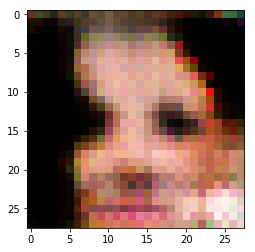

Epoch 1/1... Discriminator Loss: 0.5059... Generator Loss: 1.9984
Epoch 1/1... Discriminator Loss: 0.4658... Generator Loss: 4.7974
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 2.2016
Epoch 1/1... Discriminator Loss: 0.0123... Generator Loss: 6.7360
Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 1.7338


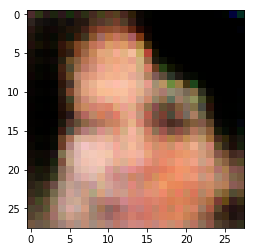

Epoch 1/1... Discriminator Loss: 3.7676... Generator Loss: 0.0403
Epoch 1/1... Discriminator Loss: 0.5050... Generator Loss: 2.1568
Epoch 1/1... Discriminator Loss: 3.9158... Generator Loss: 7.7475
Epoch 1/1... Discriminator Loss: 0.1246... Generator Loss: 4.5921
Epoch 1/1... Discriminator Loss: 0.1028... Generator Loss: 3.0438


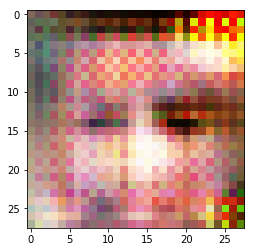

Epoch 1/1... Discriminator Loss: 0.1534... Generator Loss: 6.4834
Epoch 1/1... Discriminator Loss: 0.8249... Generator Loss: 1.4428
Epoch 1/1... Discriminator Loss: 7.9037... Generator Loss: 11.1000
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 4.8739
Epoch 1/1... Discriminator Loss: 2.1426... Generator Loss: 0.2684


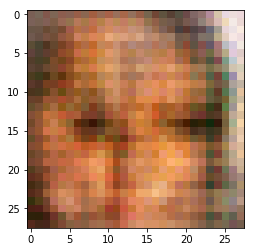

Epoch 1/1... Discriminator Loss: 8.1330... Generator Loss: 9.3237
Epoch 1/1... Discriminator Loss: 0.6187... Generator Loss: 1.7470
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.5679... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 0.4419... Generator Loss: 3.1257


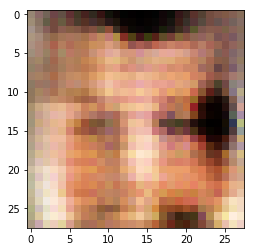

Epoch 1/1... Discriminator Loss: 1.8734... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 2.5740... Generator Loss: 5.1290
Epoch 1/1... Discriminator Loss: 2.0747... Generator Loss: 5.6492
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 0.3972... Generator Loss: 3.1065


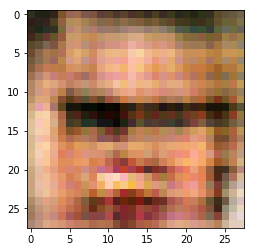

Epoch 1/1... Discriminator Loss: 1.9892... Generator Loss: 0.2329
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 1.0761
Epoch 1/1... Discriminator Loss: 6.4555... Generator Loss: 12.0490
Epoch 1/1... Discriminator Loss: 2.0435... Generator Loss: 0.3141
Epoch 1/1... Discriminator Loss: 2.0942... Generator Loss: 4.6010


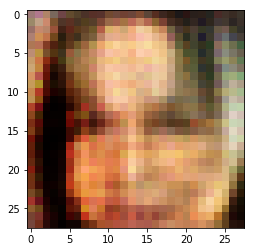

Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 3.8246
Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 3.4641
Epoch 1/1... Discriminator Loss: 4.5241... Generator Loss: 7.4704
Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 1.0717
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.7188


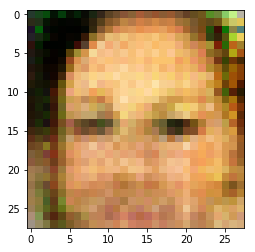

Epoch 1/1... Discriminator Loss: 0.5069... Generator Loss: 1.5331
Epoch 1/1... Discriminator Loss: 1.6157... Generator Loss: 0.4357
Epoch 1/1... Discriminator Loss: 1.8517... Generator Loss: 3.5535
Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 1.9034
Epoch 1/1... Discriminator Loss: 1.6373... Generator Loss: 0.4192


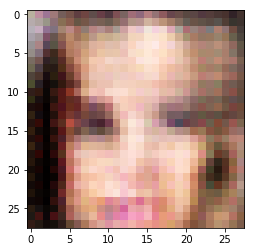

Epoch 1/1... Discriminator Loss: 0.2686... Generator Loss: 1.7814
Epoch 1/1... Discriminator Loss: 0.0163... Generator Loss: 6.2244
Epoch 1/1... Discriminator Loss: 4.5166... Generator Loss: 0.0294
Epoch 1/1... Discriminator Loss: 0.5921... Generator Loss: 2.3471
Epoch 1/1... Discriminator Loss: 2.0951... Generator Loss: 0.2357


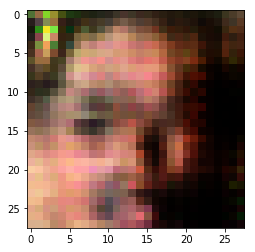

Epoch 1/1... Discriminator Loss: 0.2712... Generator Loss: 2.8032
Epoch 1/1... Discriminator Loss: 0.1059... Generator Loss: 3.3617
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.9613
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 1.1374


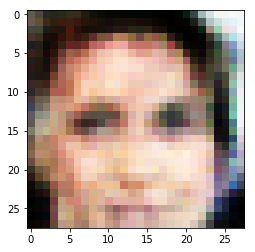

Epoch 1/1... Discriminator Loss: 0.4465... Generator Loss: 2.9673
Epoch 1/1... Discriminator Loss: 2.3006... Generator Loss: 0.1458
Epoch 1/1... Discriminator Loss: 0.1276... Generator Loss: 2.9384
Epoch 1/1... Discriminator Loss: 0.6570... Generator Loss: 1.7855
Epoch 1/1... Discriminator Loss: 0.3842... Generator Loss: 2.8844


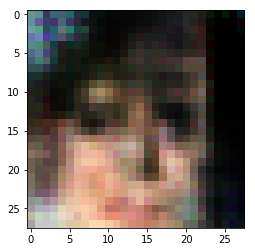

Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 4.3974
Epoch 1/1... Discriminator Loss: 0.7677... Generator Loss: 1.5162
Epoch 1/1... Discriminator Loss: 0.2875... Generator Loss: 4.5813
Epoch 1/1... Discriminator Loss: 0.0929... Generator Loss: 3.9835


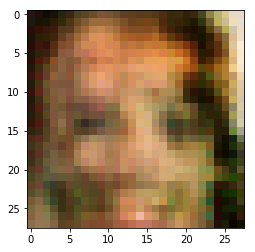

Epoch 1/1... Discriminator Loss: 2.1543... Generator Loss: 2.5004
Epoch 1/1... Discriminator Loss: 1.6406... Generator Loss: 0.4718
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 4.7649
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.7902... Generator Loss: 0.6554


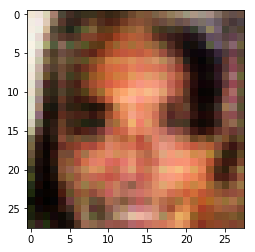

Epoch 1/1... Discriminator Loss: 0.5945... Generator Loss: 1.7026
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 5.9862
Epoch 1/1... Discriminator Loss: 0.0586... Generator Loss: 4.0126
Epoch 1/1... Discriminator Loss: 0.6303... Generator Loss: 1.5378
Epoch 1/1... Discriminator Loss: 0.1501... Generator Loss: 2.8127


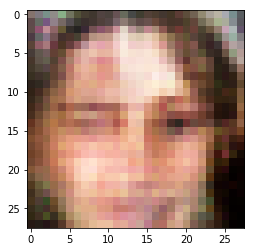

Epoch 1/1... Discriminator Loss: 0.0398... Generator Loss: 5.2121
Epoch 1/1... Discriminator Loss: 0.6046... Generator Loss: 1.6308
Epoch 1/1... Discriminator Loss: 0.1521... Generator Loss: 2.7154
Epoch 1/1... Discriminator Loss: 0.0880... Generator Loss: 3.9160
Epoch 1/1... Discriminator Loss: 3.8302... Generator Loss: 6.7453


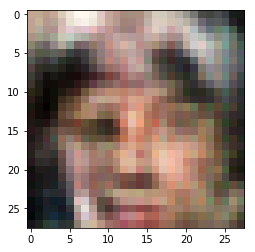

Epoch 1/1... Discriminator Loss: 0.7709... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 0.1038... Generator Loss: 4.7758
Epoch 1/1... Discriminator Loss: 0.2227... Generator Loss: 3.8491
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 1.0508
Epoch 1/1... Discriminator Loss: 0.1816... Generator Loss: 6.4886


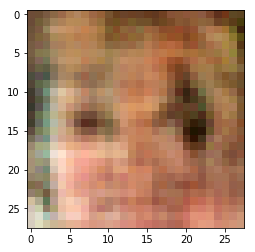

Epoch 1/1... Discriminator Loss: 0.0113... Generator Loss: 6.3948
Epoch 1/1... Discriminator Loss: 0.0546... Generator Loss: 3.6101
Epoch 1/1... Discriminator Loss: 2.1139... Generator Loss: 0.4691
Epoch 1/1... Discriminator Loss: 0.2617... Generator Loss: 2.7504
Epoch 1/1... Discriminator Loss: 0.1402... Generator Loss: 2.9238


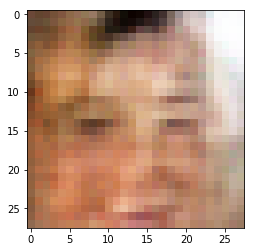

Epoch 1/1... Discriminator Loss: 0.0556... Generator Loss: 3.8810
Epoch 1/1... Discriminator Loss: 0.7991... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 3.6522... Generator Loss: 0.0980
Epoch 1/1... Discriminator Loss: 0.9149... Generator Loss: 3.0124
Epoch 1/1... Discriminator Loss: 0.5486... Generator Loss: 7.8475


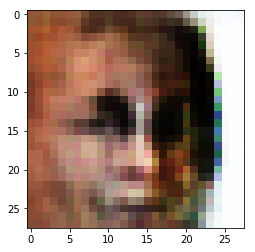

Epoch 1/1... Discriminator Loss: 0.1160... Generator Loss: 4.7628
Epoch 1/1... Discriminator Loss: 0.1153... Generator Loss: 6.6683
Epoch 1/1... Discriminator Loss: 3.8780... Generator Loss: 1.6393
Epoch 1/1... Discriminator Loss: 0.4571... Generator Loss: 4.0552
Epoch 1/1... Discriminator Loss: 0.7089... Generator Loss: 2.6013


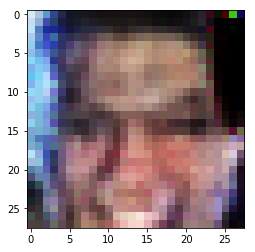

Epoch 1/1... Discriminator Loss: 0.2846... Generator Loss: 1.9533
Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 2.7668
Epoch 1/1... Discriminator Loss: 1.6343... Generator Loss: 0.3815
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 5.0802
Epoch 1/1... Discriminator Loss: 0.1349... Generator Loss: 3.2877


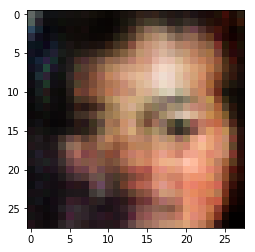

Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 0.0722... Generator Loss: 4.4977
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 1.0096
Epoch 1/1... Discriminator Loss: 0.4533... Generator Loss: 1.4739
Epoch 1/1... Discriminator Loss: 0.7445... Generator Loss: 1.3108


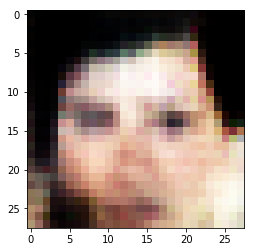

Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 3.7186
Epoch 1/1... Discriminator Loss: 0.1126... Generator Loss: 2.9262
Epoch 1/1... Discriminator Loss: 0.6374... Generator Loss: 1.3451
Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 2.7247


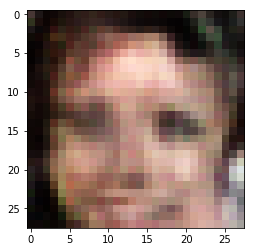

Epoch 1/1... Discriminator Loss: 0.0477... Generator Loss: 8.6503
Epoch 1/1... Discriminator Loss: 0.4585... Generator Loss: 1.7802
Epoch 1/1... Discriminator Loss: 2.1449... Generator Loss: 3.5223
Epoch 1/1... Discriminator Loss: 0.1599... Generator Loss: 3.9529
Epoch 1/1... Discriminator Loss: 0.5843... Generator Loss: 1.4156


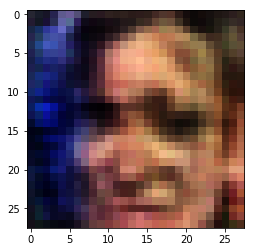

Epoch 1/1... Discriminator Loss: 0.4950... Generator Loss: 1.8039
Epoch 1/1... Discriminator Loss: 0.3019... Generator Loss: 3.9970
Epoch 1/1... Discriminator Loss: 0.1697... Generator Loss: 3.7666
Epoch 1/1... Discriminator Loss: 2.2116... Generator Loss: 6.9181
Epoch 1/1... Discriminator Loss: 0.2536... Generator Loss: 2.2118


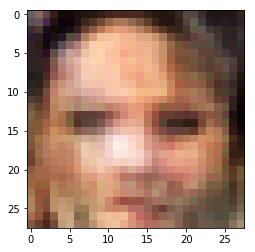

Epoch 1/1... Discriminator Loss: 2.8502... Generator Loss: 0.0810
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 1.7573
Epoch 1/1... Discriminator Loss: 0.0504... Generator Loss: 5.4950
Epoch 1/1... Discriminator Loss: 0.1398... Generator Loss: 4.0522
Epoch 1/1... Discriminator Loss: 2.5917... Generator Loss: 5.7915


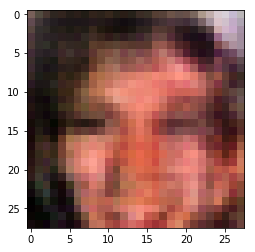

Epoch 1/1... Discriminator Loss: 0.2222... Generator Loss: 3.6541
Epoch 1/1... Discriminator Loss: 0.0576... Generator Loss: 5.0632
Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 1.1181
Epoch 1/1... Discriminator Loss: 0.0327... Generator Loss: 6.5404
Epoch 1/1... Discriminator Loss: 0.4748... Generator Loss: 1.9968


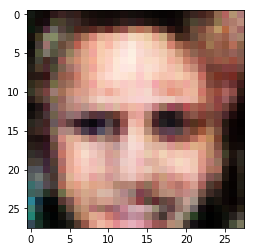

Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 0.1277... Generator Loss: 4.5252
Epoch 1/1... Discriminator Loss: 0.5443... Generator Loss: 3.4501
Epoch 1/1... Discriminator Loss: 0.1506... Generator Loss: 3.3808


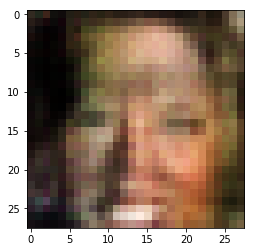

Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 0.1127... Generator Loss: 3.2394
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 0.0484... Generator Loss: 5.6240
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.1850


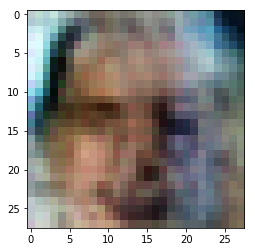

Epoch 1/1... Discriminator Loss: 2.4792... Generator Loss: 0.2410
Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 1.2623
Epoch 1/1... Discriminator Loss: 0.5291... Generator Loss: 5.3990
Epoch 1/1... Discriminator Loss: 0.3599... Generator Loss: 4.7737
Epoch 1/1... Discriminator Loss: 0.0356... Generator Loss: 5.8002


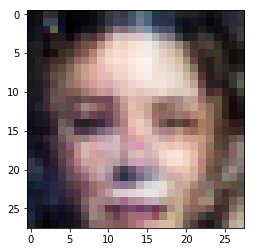

Epoch 1/1... Discriminator Loss: 0.0187... Generator Loss: 9.2807
Epoch 1/1... Discriminator Loss: 0.7626... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 0.4727... Generator Loss: 2.6438
Epoch 1/1... Discriminator Loss: 2.7856... Generator Loss: 0.1728
Epoch 1/1... Discriminator Loss: 2.7891... Generator Loss: 0.2375


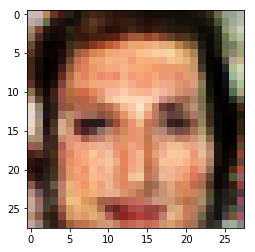

Epoch 1/1... Discriminator Loss: 0.3333... Generator Loss: 3.9601
Epoch 1/1... Discriminator Loss: 0.3961... Generator Loss: 1.9105
Epoch 1/1... Discriminator Loss: 0.1368... Generator Loss: 3.2805
Epoch 1/1... Discriminator Loss: 0.4535... Generator Loss: 3.3956
Epoch 1/1... Discriminator Loss: 0.3588... Generator Loss: 3.9544


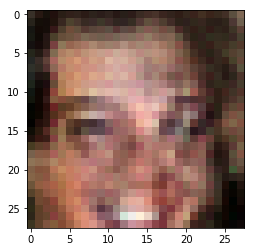

Epoch 1/1... Discriminator Loss: 0.0763... Generator Loss: 3.8636
Epoch 1/1... Discriminator Loss: 0.0867... Generator Loss: 3.6710
Epoch 1/1... Discriminator Loss: 0.0944... Generator Loss: 4.6526
Epoch 1/1... Discriminator Loss: 0.0577... Generator Loss: 4.7743
Epoch 1/1... Discriminator Loss: 0.0416... Generator Loss: 4.0107


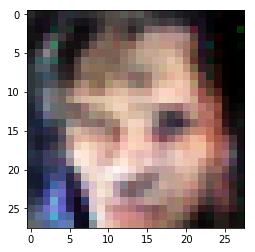

Epoch 1/1... Discriminator Loss: 0.2990... Generator Loss: 1.9433
Epoch 1/1... Discriminator Loss: 0.0717... Generator Loss: 4.1231
Epoch 1/1... Discriminator Loss: 0.3099... Generator Loss: 1.8815
Epoch 1/1... Discriminator Loss: 0.7459... Generator Loss: 1.3278
Epoch 1/1... Discriminator Loss: 0.1829... Generator Loss: 3.5173


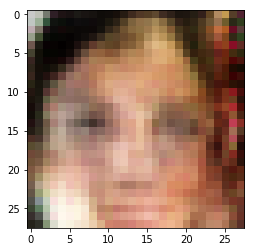

Epoch 1/1... Discriminator Loss: 0.3673... Generator Loss: 1.9165
Epoch 1/1... Discriminator Loss: 0.8583... Generator Loss: 1.1896
Epoch 1/1... Discriminator Loss: 0.0527... Generator Loss: 6.5599
Epoch 1/1... Discriminator Loss: 0.0662... Generator Loss: 4.4185
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 3.4634


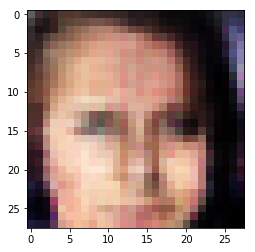

Epoch 1/1... Discriminator Loss: 1.5948... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 0.3615... Generator Loss: 2.4781
Epoch 1/1... Discriminator Loss: 0.2197... Generator Loss: 2.4804
Epoch 1/1... Discriminator Loss: 0.0207... Generator Loss: 6.4746
Epoch 1/1... Discriminator Loss: 4.8648... Generator Loss: 0.0228


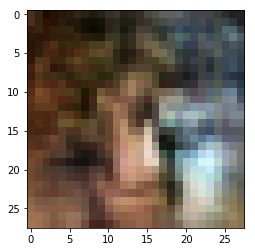

Epoch 1/1... Discriminator Loss: 2.5213... Generator Loss: 0.2516
Epoch 1/1... Discriminator Loss: 3.5163... Generator Loss: 0.1158
Epoch 1/1... Discriminator Loss: 0.1369... Generator Loss: 2.9863
Epoch 1/1... Discriminator Loss: 0.5416... Generator Loss: 6.3315
Epoch 1/1... Discriminator Loss: 0.0376... Generator Loss: 4.1428


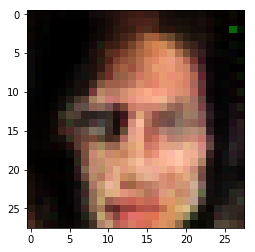

Epoch 1/1... Discriminator Loss: 0.1279... Generator Loss: 2.9701
Epoch 1/1... Discriminator Loss: 0.0629... Generator Loss: 8.0763
Epoch 1/1... Discriminator Loss: 0.0531... Generator Loss: 4.4811
Epoch 1/1... Discriminator Loss: 0.1159... Generator Loss: 3.0361
Epoch 1/1... Discriminator Loss: 0.0270... Generator Loss: 4.7987


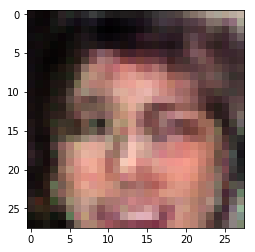

Epoch 1/1... Discriminator Loss: 0.0360... Generator Loss: 5.6878
Epoch 1/1... Discriminator Loss: 0.2391... Generator Loss: 6.7854
Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 1.5214
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 0.4907... Generator Loss: 5.8113


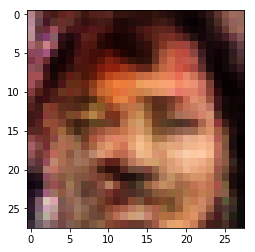

Epoch 1/1... Discriminator Loss: 0.5317... Generator Loss: 6.0746
Epoch 1/1... Discriminator Loss: 0.0157... Generator Loss: 5.9839
Epoch 1/1... Discriminator Loss: 0.3510... Generator Loss: 3.4787
Epoch 1/1... Discriminator Loss: 0.2367... Generator Loss: 5.2707
Epoch 1/1... Discriminator Loss: 0.0539... Generator Loss: 4.6645


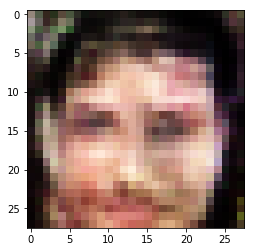

Epoch 1/1... Discriminator Loss: 0.3762... Generator Loss: 3.5554
Epoch 1/1... Discriminator Loss: 0.4205... Generator Loss: 1.6502
Epoch 1/1... Discriminator Loss: 0.0791... Generator Loss: 9.2044
Epoch 1/1... Discriminator Loss: 0.6913... Generator Loss: 8.9985
Epoch 1/1... Discriminator Loss: 0.1880... Generator Loss: 2.8304


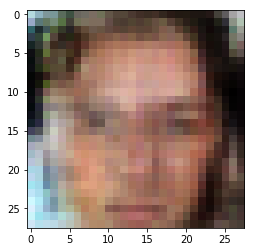

Epoch 1/1... Discriminator Loss: 0.2088... Generator Loss: 2.4423
Epoch 1/1... Discriminator Loss: 0.2927... Generator Loss: 2.6339
Epoch 1/1... Discriminator Loss: 0.0597... Generator Loss: 4.3939
Epoch 1/1... Discriminator Loss: 4.1225... Generator Loss: 0.0579
Epoch 1/1... Discriminator Loss: 0.2475... Generator Loss: 2.6562


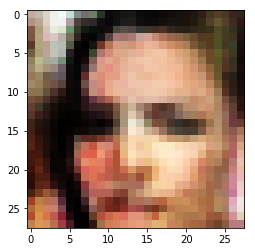

Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 4.0918... Generator Loss: 0.2953
Epoch 1/1... Discriminator Loss: 0.3108... Generator Loss: 2.7714
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 0.1534... Generator Loss: 3.2393


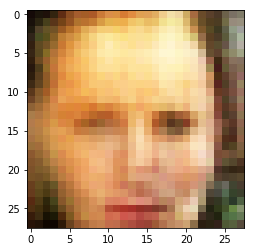

Epoch 1/1... Discriminator Loss: 1.7838... Generator Loss: 6.3558
Epoch 1/1... Discriminator Loss: 0.1030... Generator Loss: 4.5462
Epoch 1/1... Discriminator Loss: 0.3948... Generator Loss: 2.3410
Epoch 1/1... Discriminator Loss: 0.7530... Generator Loss: 1.6608
Epoch 1/1... Discriminator Loss: 0.1506... Generator Loss: 2.7911


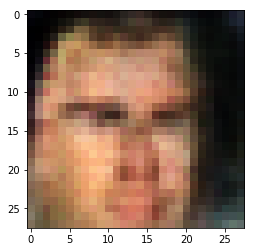

Epoch 1/1... Discriminator Loss: 0.0170... Generator Loss: 6.6048
Epoch 1/1... Discriminator Loss: 0.0843... Generator Loss: 9.0386
Epoch 1/1... Discriminator Loss: 0.3348... Generator Loss: 2.3078
Epoch 1/1... Discriminator Loss: 0.0770... Generator Loss: 3.6615
Epoch 1/1... Discriminator Loss: 0.4440... Generator Loss: 6.0750


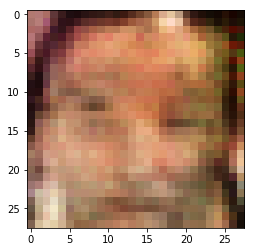

Epoch 1/1... Discriminator Loss: 0.4612... Generator Loss: 2.0843
Epoch 1/1... Discriminator Loss: 0.2455... Generator Loss: 2.7092
Epoch 1/1... Discriminator Loss: 0.1145... Generator Loss: 5.1255
Epoch 1/1... Discriminator Loss: 0.2478... Generator Loss: 2.6001
Epoch 1/1... Discriminator Loss: 0.0539... Generator Loss: 4.6815


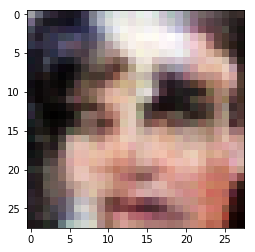

Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 4.6367
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 0.2201... Generator Loss: 2.4158
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 0.4517... Generator Loss: 5.6101


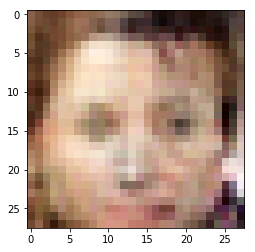

Epoch 1/1... Discriminator Loss: 0.0082... Generator Loss: 6.7890
Epoch 1/1... Discriminator Loss: 1.7207... Generator Loss: 7.1918
Epoch 1/1... Discriminator Loss: 0.0980... Generator Loss: 3.7330
Epoch 1/1... Discriminator Loss: 0.1954... Generator Loss: 2.4555
Epoch 1/1... Discriminator Loss: 0.4798... Generator Loss: 4.2638


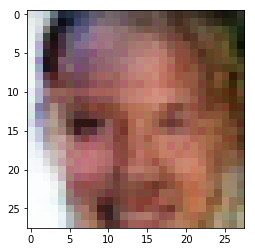

Epoch 1/1... Discriminator Loss: 0.0363... Generator Loss: 4.2062
Epoch 1/1... Discriminator Loss: 0.7241... Generator Loss: 1.8277
Epoch 1/1... Discriminator Loss: 0.2526... Generator Loss: 1.9498
Epoch 1/1... Discriminator Loss: 0.0189... Generator Loss: 8.4924
Epoch 1/1... Discriminator Loss: 0.1058... Generator Loss: 3.7036


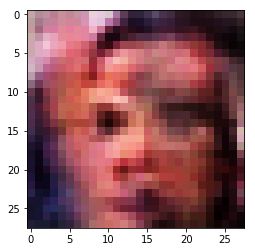

Epoch 1/1... Discriminator Loss: 0.4232... Generator Loss: 1.8043
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 0.1066... Generator Loss: 5.0845
Epoch 1/1... Discriminator Loss: 0.0943... Generator Loss: 3.2187
Epoch 1/1... Discriminator Loss: 0.0500... Generator Loss: 5.0314


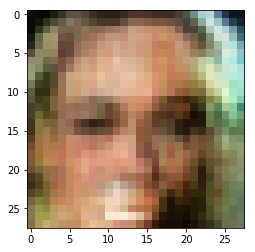

Epoch 1/1... Discriminator Loss: 0.0972... Generator Loss: 2.9372
Epoch 1/1... Discriminator Loss: 0.0822... Generator Loss: 4.2931
Epoch 1/1... Discriminator Loss: 0.2368... Generator Loss: 4.1389
Epoch 1/1... Discriminator Loss: 0.3701... Generator Loss: 1.4920
Epoch 1/1... Discriminator Loss: 0.3224... Generator Loss: 2.5666


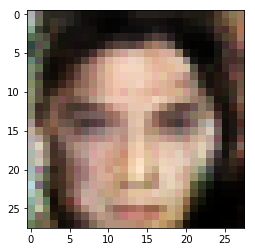

Epoch 1/1... Discriminator Loss: 0.1779... Generator Loss: 3.3952
Epoch 1/1... Discriminator Loss: 1.5154... Generator Loss: 1.2005
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 0.3646... Generator Loss: 2.1172
Epoch 1/1... Discriminator Loss: 0.1745... Generator Loss: 3.4436


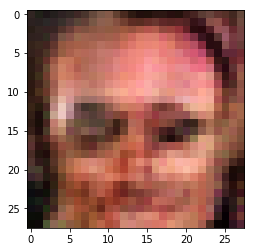

Epoch 1/1... Discriminator Loss: 0.0122... Generator Loss: 8.7934
Epoch 1/1... Discriminator Loss: 0.3200... Generator Loss: 3.3105
Epoch 1/1... Discriminator Loss: 0.4192... Generator Loss: 1.8372
Epoch 1/1... Discriminator Loss: 0.0898... Generator Loss: 5.3416
Epoch 1/1... Discriminator Loss: 0.1238... Generator Loss: 4.1762


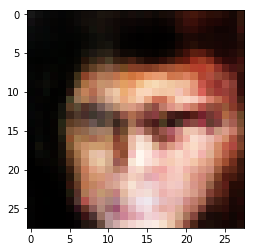

Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 4.4742
Epoch 1/1... Discriminator Loss: 0.3074... Generator Loss: 3.2280
Epoch 1/1... Discriminator Loss: 0.4878... Generator Loss: 1.2696
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.5294


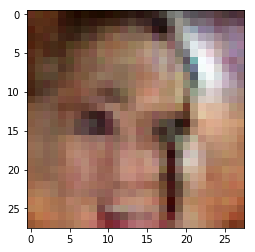

Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 3.5079
Epoch 1/1... Discriminator Loss: 0.0447... Generator Loss: 4.0276
Epoch 1/1... Discriminator Loss: 0.1807... Generator Loss: 2.4992
Epoch 1/1... Discriminator Loss: 0.3039... Generator Loss: 2.0674
Epoch 1/1... Discriminator Loss: 0.4108... Generator Loss: 2.2781


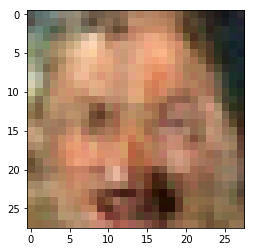

Epoch 1/1... Discriminator Loss: 0.0822... Generator Loss: 3.5028
Epoch 1/1... Discriminator Loss: 1.6720... Generator Loss: 0.4383
Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 5.2562
Epoch 1/1... Discriminator Loss: 0.0785... Generator Loss: 3.8770
Epoch 1/1... Discriminator Loss: 0.2159... Generator Loss: 2.3031


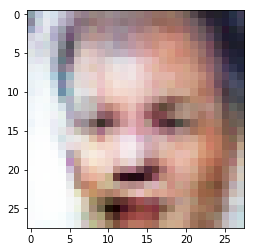

Epoch 1/1... Discriminator Loss: 0.0291... Generator Loss: 5.3522
Epoch 1/1... Discriminator Loss: 0.3428... Generator Loss: 5.7471
Epoch 1/1... Discriminator Loss: 0.1589... Generator Loss: 2.3615
Epoch 1/1... Discriminator Loss: 0.0285... Generator Loss: 5.0487
Epoch 1/1... Discriminator Loss: 0.1222... Generator Loss: 5.1445


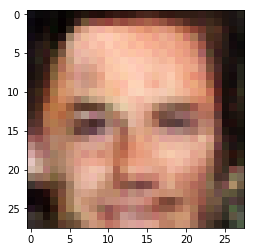

Epoch 1/1... Discriminator Loss: 0.0178... Generator Loss: 7.4447
Epoch 1/1... Discriminator Loss: 0.2242... Generator Loss: 2.7568
Epoch 1/1... Discriminator Loss: 0.1273... Generator Loss: 3.2229
Epoch 1/1... Discriminator Loss: 0.0085... Generator Loss: 7.2515
Epoch 1/1... Discriminator Loss: 0.0253... Generator Loss: 5.5223


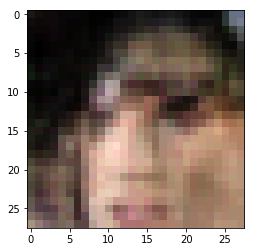

Epoch 1/1... Discriminator Loss: 0.0092... Generator Loss: 6.2067
Epoch 1/1... Discriminator Loss: 0.3538... Generator Loss: 5.4160
Epoch 1/1... Discriminator Loss: 0.0740... Generator Loss: 4.0040
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 1.0999
Epoch 1/1... Discriminator Loss: 2.6550... Generator Loss: 0.2044


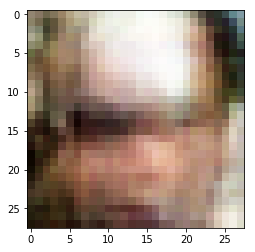

Epoch 1/1... Discriminator Loss: 3.3109... Generator Loss: 0.1391
Epoch 1/1... Discriminator Loss: 0.1556... Generator Loss: 3.1165
Epoch 1/1... Discriminator Loss: 0.0325... Generator Loss: 5.1407
Epoch 1/1... Discriminator Loss: 0.1548... Generator Loss: 2.4406
Epoch 1/1... Discriminator Loss: 0.2633... Generator Loss: 2.8333


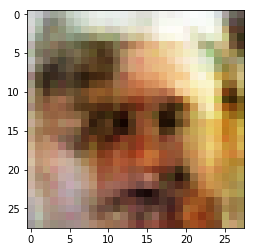

Epoch 1/1... Discriminator Loss: 2.0088... Generator Loss: 0.3056
Epoch 1/1... Discriminator Loss: 0.0500... Generator Loss: 4.3382
Epoch 1/1... Discriminator Loss: 0.0622... Generator Loss: 7.6709
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 0.1795... Generator Loss: 3.4238


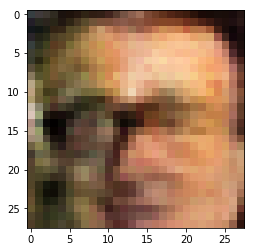

Epoch 1/1... Discriminator Loss: 3.2369... Generator Loss: 0.0979


In [161]:
#CelebA setting 1
#alpha=0.2
batch_size = 32
z_dim = 128
learning_rate = 0.00125
beta1 = 0.5
losses = []


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses=train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

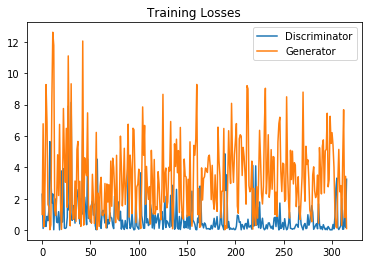

In [162]:
#CelebA setting 1 Result
fig, ax = pyplot.subplots()
losses = np.array(losses)
pyplot.plot(losses.T[0], label='Discriminator')
pyplot.plot(losses.T[1], label='Generator')
pyplot.title("Training Losses")
pyplot.legend()

Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 1.5722
Epoch 1/1... Discriminator Loss: 13.6557... Generator Loss: 0.0032
Epoch 1/1... Discriminator Loss: 18.6482... Generator Loss: 0.0000
Epoch 1/1... Discriminator Loss: 0.2857... Generator Loss: 3.1867
Epoch 1/1... Discriminator Loss: 9.3166... Generator Loss: 16.4885


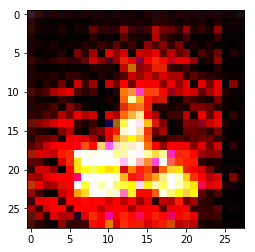

Epoch 1/1... Discriminator Loss: 2.0750... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 0.1658... Generator Loss: 3.9614
Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 1.6035
Epoch 1/1... Discriminator Loss: 0.0330... Generator Loss: 10.1929
Epoch 1/1... Discriminator Loss: 8.7332... Generator Loss: 12.3371


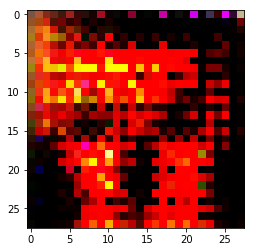

Epoch 1/1... Discriminator Loss: 3.0529... Generator Loss: 1.3836
Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 7.7372
Epoch 1/1... Discriminator Loss: 0.1244... Generator Loss: 4.3642
Epoch 1/1... Discriminator Loss: 0.5875... Generator Loss: 1.2629
Epoch 1/1... Discriminator Loss: 0.7115... Generator Loss: 1.3400


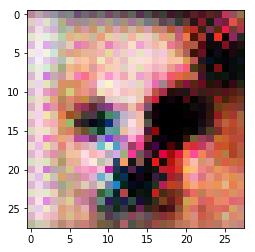

Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 3.3997... Generator Loss: 0.0647
Epoch 1/1... Discriminator Loss: 4.1460... Generator Loss: 0.0526
Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.6704


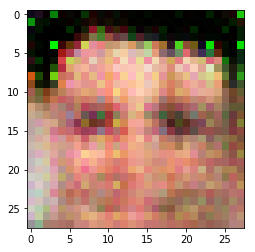

Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 1.8457
Epoch 1/1... Discriminator Loss: 3.3916... Generator Loss: 2.8984
Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 2.2611
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 4.1233
Epoch 1/1... Discriminator Loss: 2.8182... Generator Loss: 3.8255


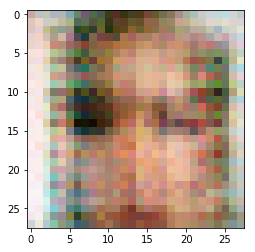

Epoch 1/1... Discriminator Loss: 2.2858... Generator Loss: 4.5680
Epoch 1/1... Discriminator Loss: 1.5680... Generator Loss: 0.4338
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 0.8420... Generator Loss: 1.3890
Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 0.8594


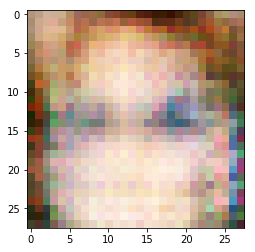

Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 2.1877... Generator Loss: 0.3875
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 1.1080
Epoch 1/1... Discriminator Loss: 4.8368... Generator Loss: 0.0268
Epoch 1/1... Discriminator Loss: 0.8173... Generator Loss: 1.0431


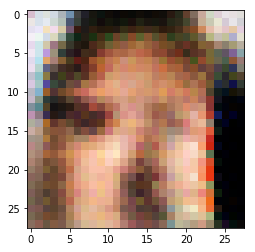

Epoch 1/1... Discriminator Loss: 1.6816... Generator Loss: 0.3621
Epoch 1/1... Discriminator Loss: 0.6194... Generator Loss: 1.4365
Epoch 1/1... Discriminator Loss: 1.6309... Generator Loss: 0.4084
Epoch 1/1... Discriminator Loss: 0.4340... Generator Loss: 1.7614
Epoch 1/1... Discriminator Loss: 0.8139... Generator Loss: 0.8720


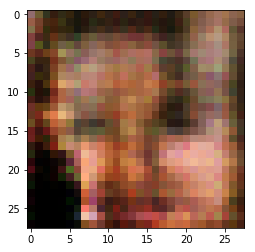

Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.1052
Epoch 1/1... Discriminator Loss: 0.7585... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 3.0054... Generator Loss: 0.4299
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 1.5934
Epoch 1/1... Discriminator Loss: 0.7759... Generator Loss: 1.2668


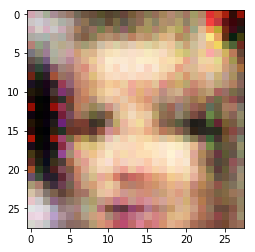

Epoch 1/1... Discriminator Loss: 0.2663... Generator Loss: 1.7462
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 0.4560
Epoch 1/1... Discriminator Loss: 1.7116... Generator Loss: 3.0802
Epoch 1/1... Discriminator Loss: 0.4860... Generator Loss: 1.4890


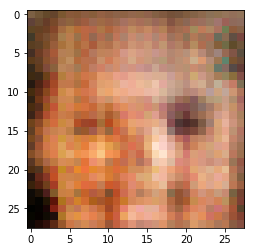

Epoch 1/1... Discriminator Loss: 1.7997... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 1.3257
Epoch 1/1... Discriminator Loss: 1.8501... Generator Loss: 0.2982
Epoch 1/1... Discriminator Loss: 0.5956... Generator Loss: 1.0910
Epoch 1/1... Discriminator Loss: 1.6080... Generator Loss: 0.5062


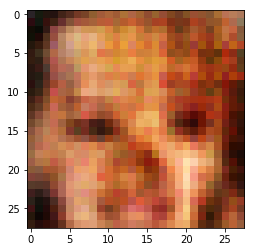

Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.5241
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 3.1838
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 0.6548


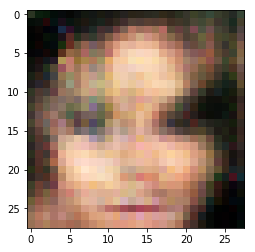

Epoch 1/1... Discriminator Loss: 0.4312... Generator Loss: 1.5419
Epoch 1/1... Discriminator Loss: 1.6047... Generator Loss: 0.3926
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 1.9446
Epoch 1/1... Discriminator Loss: 1.6735... Generator Loss: 2.6190
Epoch 1/1... Discriminator Loss: 0.1737... Generator Loss: 2.5027


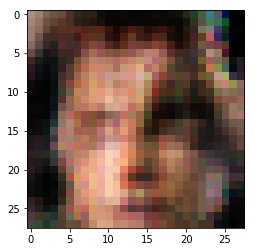

Epoch 1/1... Discriminator Loss: 0.6274... Generator Loss: 1.3411
Epoch 1/1... Discriminator Loss: 0.3165... Generator Loss: 1.9360
Epoch 1/1... Discriminator Loss: 0.4158... Generator Loss: 1.3731
Epoch 1/1... Discriminator Loss: 0.4382... Generator Loss: 1.9144
Epoch 1/1... Discriminator Loss: 2.5229... Generator Loss: 0.1893


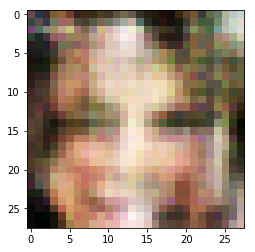

Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 1.0721
Epoch 1/1... Discriminator Loss: 0.1774... Generator Loss: 2.3581
Epoch 1/1... Discriminator Loss: 0.6185... Generator Loss: 1.4089
Epoch 1/1... Discriminator Loss: 2.2754... Generator Loss: 0.2546
Epoch 1/1... Discriminator Loss: 2.0656... Generator Loss: 0.8963


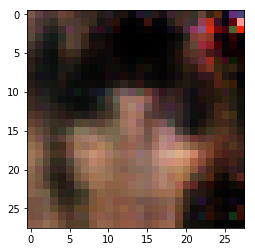

Epoch 1/1... Discriminator Loss: 1.8896... Generator Loss: 0.2376
Epoch 1/1... Discriminator Loss: 0.0344... Generator Loss: 4.4908
Epoch 1/1... Discriminator Loss: 2.9789... Generator Loss: 0.0855
Epoch 1/1... Discriminator Loss: 1.6364... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.6054


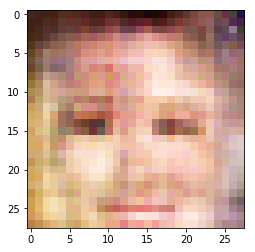

Epoch 1/1... Discriminator Loss: 0.4533... Generator Loss: 1.4715
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 0.3131... Generator Loss: 2.6595


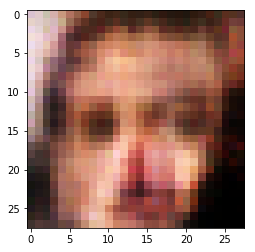

Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 1.2209
Epoch 1/1... Discriminator Loss: 0.6283... Generator Loss: 1.7795
Epoch 1/1... Discriminator Loss: 2.1299... Generator Loss: 3.1332
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.5526
Epoch 1/1... Discriminator Loss: 1.8345... Generator Loss: 0.3372


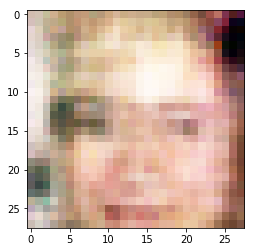

Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 0.6675... Generator Loss: 2.0781
Epoch 1/1... Discriminator Loss: 0.0329... Generator Loss: 5.4419
Epoch 1/1... Discriminator Loss: 0.0389... Generator Loss: 5.8595
Epoch 1/1... Discriminator Loss: 0.1349... Generator Loss: 2.3990


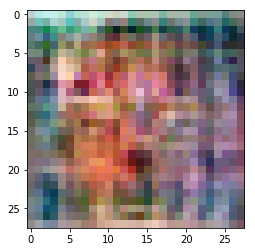

Epoch 1/1... Discriminator Loss: 0.0168... Generator Loss: 4.8994
Epoch 1/1... Discriminator Loss: 0.2049... Generator Loss: 2.3949
Epoch 1/1... Discriminator Loss: 0.0160... Generator Loss: 4.6804
Epoch 1/1... Discriminator Loss: 0.0103... Generator Loss: 5.2099
Epoch 1/1... Discriminator Loss: 0.0321... Generator Loss: 3.7395


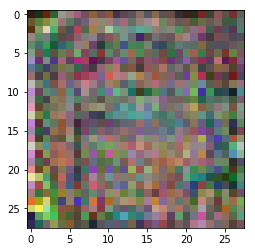

Epoch 1/1... Discriminator Loss: 0.0184... Generator Loss: 4.3128
Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 7.9303
Epoch 1/1... Discriminator Loss: 0.0091... Generator Loss: 5.5201
Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 7.4033
Epoch 1/1... Discriminator Loss: 0.0016... Generator Loss: 7.6373


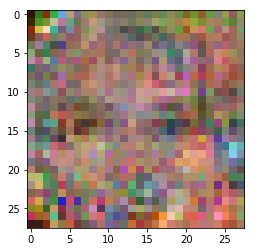

Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 7.4067
Epoch 1/1... Discriminator Loss: 0.0051... Generator Loss: 5.6799
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 8.0485
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 8.1120
Epoch 1/1... Discriminator Loss: 0.0169... Generator Loss: 4.3451


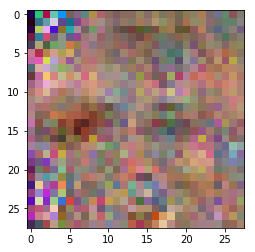

Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 8.1308
Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 6.5803
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 12.3074
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 12.9367
Epoch 1/1... Discriminator Loss: 0.3409... Generator Loss: 2.1908


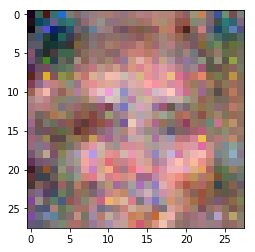

Epoch 1/1... Discriminator Loss: 0.4422... Generator Loss: 2.1230
Epoch 1/1... Discriminator Loss: 0.2677... Generator Loss: 2.0882
Epoch 1/1... Discriminator Loss: 0.8780... Generator Loss: 2.6430
Epoch 1/1... Discriminator Loss: 0.3369... Generator Loss: 2.0729
Epoch 1/1... Discriminator Loss: 0.0753... Generator Loss: 4.7023


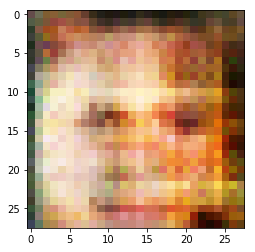

Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 0.7433... Generator Loss: 1.5435
Epoch 1/1... Discriminator Loss: 0.6008... Generator Loss: 1.0954
Epoch 1/1... Discriminator Loss: 0.3596... Generator Loss: 3.6801
Epoch 1/1... Discriminator Loss: 0.6570... Generator Loss: 1.7075


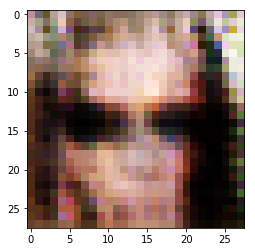

Epoch 1/1... Discriminator Loss: 0.8091... Generator Loss: 2.8171
Epoch 1/1... Discriminator Loss: 1.7925... Generator Loss: 0.3612
Epoch 1/1... Discriminator Loss: 0.3754... Generator Loss: 2.1223
Epoch 1/1... Discriminator Loss: 0.6908... Generator Loss: 2.6347
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 5.6398


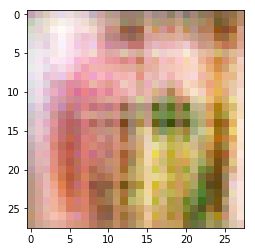

Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 1.1186
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.5018
Epoch 1/1... Discriminator Loss: 0.7634... Generator Loss: 3.9583
Epoch 1/1... Discriminator Loss: 0.4806... Generator Loss: 1.6656
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 4.1209


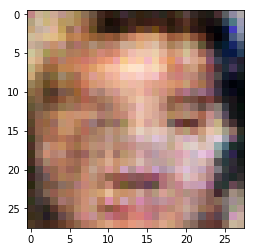

Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 1.7466
Epoch 1/1... Discriminator Loss: 2.1473... Generator Loss: 0.2504
Epoch 1/1... Discriminator Loss: 2.6183... Generator Loss: 0.1397
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 0.5991... Generator Loss: 2.2106


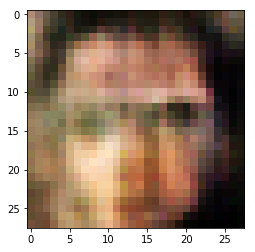

Epoch 1/1... Discriminator Loss: 0.2910... Generator Loss: 2.9440
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 1.0096
Epoch 1/1... Discriminator Loss: 0.6713... Generator Loss: 1.9121
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.0806


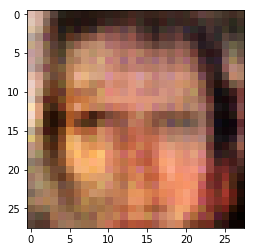

Epoch 1/1... Discriminator Loss: 0.8703... Generator Loss: 0.9970
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 0.7548... Generator Loss: 1.3092
Epoch 1/1... Discriminator Loss: 1.8256... Generator Loss: 0.4860


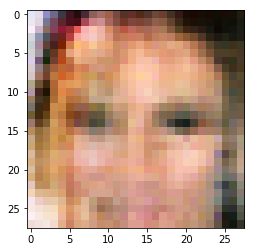

Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.5320
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 2.6257... Generator Loss: 0.1129


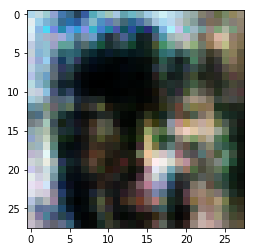

Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 1.8566
Epoch 1/1... Discriminator Loss: 0.4831... Generator Loss: 1.4862


In [163]:
#CelebA setting 2
#alpha=0.2
batch_size = 64
z_dim = 256
learning_rate = 0.0025
beta1 = 0.5
losses = []


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses=train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

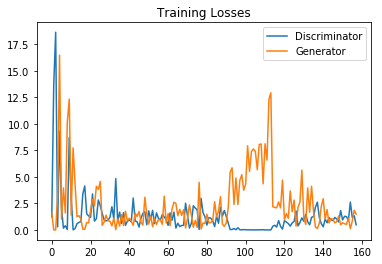

In [164]:
#CelebA setting 2 Result
fig, ax = pyplot.subplots()
losses = np.array(losses)
pyplot.plot(losses.T[0], label='Discriminator')
pyplot.plot(losses.T[1], label='Generator')
pyplot.title("Training Losses")
pyplot.legend()

Epoch 1/1... Discriminator Loss: 8.0815... Generator Loss: 6.9741
Epoch 1/1... Discriminator Loss: 3.1719... Generator Loss: 2.1470
Epoch 1/1... Discriminator Loss: 5.2043... Generator Loss: 6.6639
Epoch 1/1... Discriminator Loss: 2.3120... Generator Loss: 1.9046
Epoch 1/1... Discriminator Loss: 3.4561... Generator Loss: 0.3256


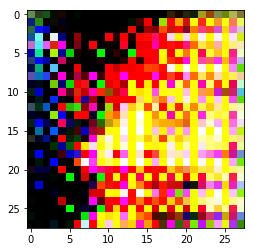

Epoch 1/1... Discriminator Loss: 0.2949... Generator Loss: 2.0547
Epoch 1/1... Discriminator Loss: 0.7882... Generator Loss: 11.0554
Epoch 1/1... Discriminator Loss: 0.1623... Generator Loss: 5.5867
Epoch 1/1... Discriminator Loss: 0.0505... Generator Loss: 6.6028
Epoch 1/1... Discriminator Loss: 13.0656... Generator Loss: 0.0013


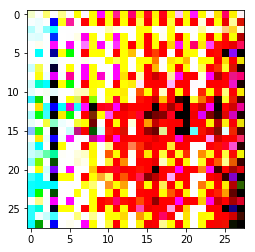

Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 1.5920
Epoch 1/1... Discriminator Loss: 0.2249... Generator Loss: 3.9610
Epoch 1/1... Discriminator Loss: 0.0723... Generator Loss: 3.1234
Epoch 1/1... Discriminator Loss: 0.0281... Generator Loss: 4.6541
Epoch 1/1... Discriminator Loss: 0.0295... Generator Loss: 4.0748


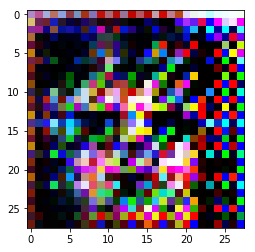

Epoch 1/1... Discriminator Loss: 0.0249... Generator Loss: 5.2887
Epoch 1/1... Discriminator Loss: 0.0181... Generator Loss: 4.5448
Epoch 1/1... Discriminator Loss: 0.0447... Generator Loss: 3.5812
Epoch 1/1... Discriminator Loss: 2.2323... Generator Loss: 1.4943
Epoch 1/1... Discriminator Loss: 2.2669... Generator Loss: 0.8286


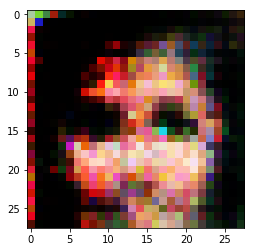

Epoch 1/1... Discriminator Loss: 1.8908... Generator Loss: 0.3084
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 0.6273... Generator Loss: 1.5861
Epoch 1/1... Discriminator Loss: 0.7289... Generator Loss: 1.2488
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.8944


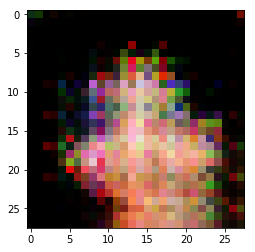

Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 1.2487
Epoch 1/1... Discriminator Loss: 1.6902... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.5168
Epoch 1/1... Discriminator Loss: 2.0121... Generator Loss: 2.5427
Epoch 1/1... Discriminator Loss: 1.8760... Generator Loss: 0.3700


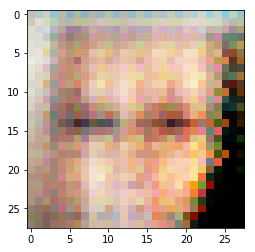

Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.4859
Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 1.4586
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 3.2540... Generator Loss: 3.9133


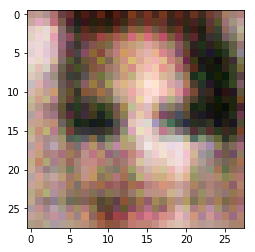

Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 2.1704... Generator Loss: 0.1961
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 0.8958


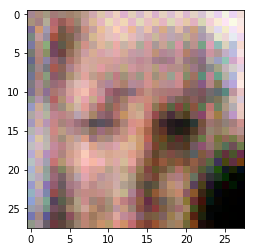

Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 1.1053
Epoch 1/1... Discriminator Loss: 1.9090... Generator Loss: 0.2314
Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 1.4374
Epoch 1/1... Discriminator Loss: 2.6260... Generator Loss: 2.9237
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.6984


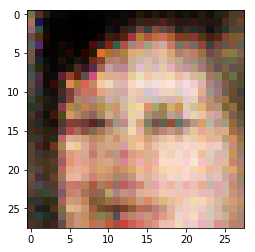

Epoch 1/1... Discriminator Loss: 1.8384... Generator Loss: 2.8895
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.1840
Epoch 1/1... Discriminator Loss: 3.6992... Generator Loss: 3.6850
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 0.6400... Generator Loss: 1.2050


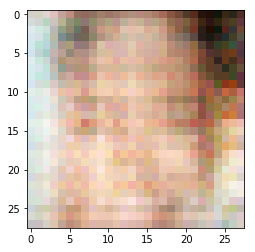

Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.4488
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.4968
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 0.7435


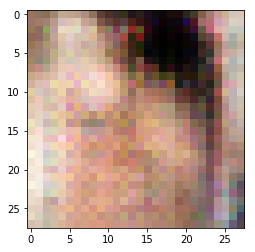

Epoch 1/1... Discriminator Loss: 1.5589... Generator Loss: 1.5955
Epoch 1/1... Discriminator Loss: 2.3660... Generator Loss: 2.7456
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 1.4195
Epoch 1/1... Discriminator Loss: 0.8544... Generator Loss: 1.2426
Epoch 1/1... Discriminator Loss: 1.6051... Generator Loss: 0.4574


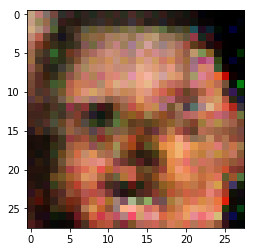

Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 1.5930
Epoch 1/1... Discriminator Loss: 0.8301... Generator Loss: 1.4104
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 0.6369


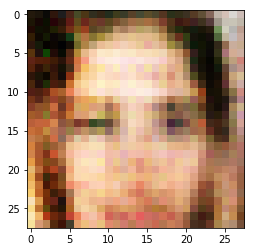

Epoch 1/1... Discriminator Loss: 2.5943... Generator Loss: 0.1355
Epoch 1/1... Discriminator Loss: 1.7181... Generator Loss: 0.3579
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.4120
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 2.2660... Generator Loss: 0.3388


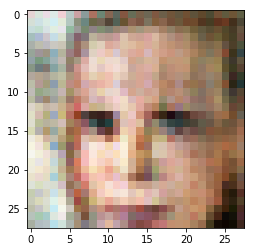

Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 2.0149
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 2.2122... Generator Loss: 0.2036
Epoch 1/1... Discriminator Loss: 4.5927... Generator Loss: 4.1501
Epoch 1/1... Discriminator Loss: 1.7871... Generator Loss: 0.3003


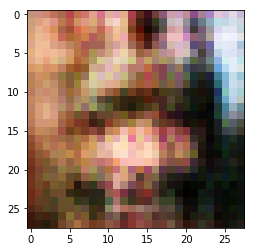

Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 1.6831
Epoch 1/1... Discriminator Loss: 1.5583... Generator Loss: 1.2127
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 1.2688
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.5481


In [ ]:
#Final Result CelebA
#alpha=0.2
batch_size = 128
z_dim = 512
learning_rate = 0.005
beta1 = 0.5
losses = []


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses=train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

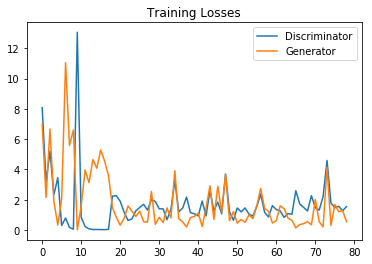

In [171]:
#Final Result CelebA
fig, ax = pyplot.subplots()
losses = np.array(losses)
pyplot.plot(losses.T[0], label='Discriminator')
pyplot.plot(losses.T[1], label='Generator')
pyplot.title("Training Losses")
pyplot.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.